# SNN-CNN-Univariate-Sigma-Delta-Network-SDNN-LAVA

In [ ]:
# Install dependencies
!sudo apt-get update -qq
!sudo apt-get install -y software-properties-common wget

# Add Deadsnakes PPA and install Python 3.10
!sudo add-apt-repository ppa:deadsnakes/ppa -y
!sudo apt-get update -qq
!sudo apt-get install -y python3.10 python3.10-venv python3.10-dev

# Create a virtual environment named 'lava-env'
!python3.10 -m venv lava-env

# Upgrade pip in the virtual environment
!lava-env/bin/pip install --upgrade pip

# Install Lava DL 0.6.0 from GitHub
!lava-env/bin/pip install git+https://github.com/lava-nc/lava-dl.git@v0.6.0

# Install ipykernel in the virtual environment
!lava-env/bin/pip install ipykernel

# Add the virtual environment as a new Jupyter kernel
!lava-env/bin/python -m ipykernel install --user --name=lava-env --display-name "Python 3.10 (lava-env)"

# Restart the runtime to apply changes
import os
os.kill(os.getpid(), 9)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu/ jammy main'
Description:
This PPA contains more recent Python versions packaged for Ubuntu.

Disclaimer: there's no guarantee of timely updates in case of security problems or other issues. If you want to use them in a security-or-otherwise-critical environment (say, on a production server), you do so at your own risk.

Update Note
Please use this repository instead of ppa:fkrull/deadsnakes.

Reporting Issues

Issues can be reported in the master issue tracker at:
https://github.com/deadsnakes/issues/i

In [6]:
# Check the installed Python version
!python --version


Python 3.11.11


In [ ]:
import cupy as cp
print(cp.__version__)
print(cp.show_config())

12.2.0
OS                           : Linux-6.1.85+-x86_64-with-glibc2.35
Python Version               : 3.10.12
CuPy Version                 : 12.2.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.26.4
SciPy Version                : 1.13.1
Cython Build Version         : 0.29.36
Cython Runtime Version       : 3.0.11
CUDA Root                    : /usr/local/cuda
nvcc PATH                    : /usr/local/cuda/bin/nvcc
CUDA Build Version           : 12020
CUDA Driver Version          : 12020
CUDA Runtime Version         : 12010
cuBLAS Version               : (available)
cuFFT Version                : 11002
cuRAND Version               : 10302
cuSOLVER Version             : (11, 5, 2)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 2)
Thrust Version               : 200101
CUB Build Version            : 200101
Jitify Build Version         : <unknown>
cuDNN Build Version          : 8801
cuDNN Version                : 8902
NCCL Buil

In [ ]:
pip install cupy-cuda12x

In [ ]:
!pip install lava

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 12.2 MB/s eta 0:00:00


In [ ]:
!pip install lava-dl

ERROR: Ignored the following versions that require a different python version: 0.4.0 Requires-Python >=3.8,<3.11; 0.5.0 Requires-Python >=3.8,<3.11; 0.6.0 Requires-Python <3.11,>=3.10
ERROR: Could not find a version that satisfies the requirement lava-dl (from versions: none)
ERROR: No matching distribution found for lava-dl


# CuSPARSE Optimization

# MLP cuSPARSE

In [10]:
#!/usr/bin/env python
# coding: utf-8

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import subprocess
import time

import lava
import lava.lib.dl.slayer as slayer
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# ---- Extra imports for sparse operations ----
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cupy_csr_matrix
from scipy.sparse import csr_matrix as scipy_csr_matrix


# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    if not os.path.exists(log_file):
        print(f"Log file {log_file} does not exist.")
        return 0.0, 0.0

    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])
    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)
    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    """
    Clears the existing log file if it exists.
    """
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")


# ---------------------------------------------------------------------
# 2) Load, Preprocess Data
#    (Same logic, just modularized from the second script approach)
# ---------------------------------------------------------------------
def load_and_preprocess_data(csv_file, sequence_length=3, train_split=0.8):
    """
    Load and preprocess the data from a CSV file.

    Parameters:
    - csv_file: Path to the CSV file.
    - sequence_length: Number of time steps in each input sequence.
    - train_split: Fraction of data to be used for training.

    Returns:
    - train_X, train_y: Training input sequences and targets.
    - test_X, test_y: Testing input sequences and targets.
    - scaler: Fitted MinMaxScaler object.
    """
    data = read_csv(csv_file, parse_dates=['date'], index_col='date')
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()

    # Select the 6th column (index=5), drop NaN
    data = data.iloc[:, 5]
    print("Data shape after selecting column:", data.shape)
    print("Number of NaNs:", data.isnull().sum())
    data.info()

    data = data.dropna().astype('float32')
    # Scale data
    data_np = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_np)

    train_size = int(len(data_scaled) * train_split)
    train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

    def to_sequences(dataset, seq_size=3):
        x, y = [], []
        for i in range(len(dataset) - seq_size - 1):
            window = dataset[i:i + seq_size, 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train_data, sequence_length)
    test_X, test_y = to_sequences(test_data,  sequence_length)

    print("Training data shape:", train_X.shape, "Training targets shape:", train_y.shape)
    print("Testing data shape:", test_X.shape,  "Testing targets shape:",  test_y.shape)

    # Convert to torch tensor
    train_X = torch.tensor(train_X).float()
    train_y = torch.tensor(train_y).float()
    test_X  = torch.tensor(test_X).float()
    test_y  = torch.tensor(test_y).float()

    # Reshape for spiking networks that expect 5D [N, T, C, H, W]
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1, 1, 1))
    test_X  = test_X.reshape((test_X.shape[0],  test_X.shape[1],  1, 1, 1))

    print("Reshaped Training data:", train_X.shape)
    print("Reshaped Testing  data:", test_X.shape)

    return train_X, train_y, test_X, test_y, scaler


# ---------------------------------------------------------------------
# 3) Spiking Network Definition with cuSPARSE Integration
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {  # sigma-delta neuron parameters
            'threshold':     0.05,
            'tau_grad':      0.05,
            'scale_grad':    1,
            'requires_grad': True,
            'shared_param':  True,
            'activation':    F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),

            # Example conv layers
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 3, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),

            # Flatten
            slayer.block.sigma_delta.Flatten(),

            # Dense layers
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),

            # Output
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        """
        Forward pass through the network using sparse operations with SciPy + CuPy.
        Returns (output, net_loss, count).
        We'll set net_loss and count=0 since lam=0 or ignoring spike counts.
        """
        for i, block in enumerate(self.blocks):
            # Apply the current block
            x = block(x)
            # Debug prints
            # print(f"[forward] Block {i}: x shape after processing: {x.shape}")

            # ----------------------------------------------------
            #  Apply Sparse Operations Manually After Certain Blocks
            # ----------------------------------------------------

            # If this block is a Conv
            if isinstance(block, slayer.block.sigma_delta.Conv):
                # For demonstration, let's apply sparse ops only after the second Conv
                if i == 1:
                    # After Conv1 (block index=1), let's skip manual ops
                    # (due to shape mismatch or design choice)
                    # print("Block 1: Skipping manual sparse operations for Conv1.")
                    continue

                # For the second Conv (block index=2), do the sparse approach
                # print(f"Block {i}: Performing manual sparse operations for Conv2.")
                batch_size, out_channels, height, width, depth = x.shape

                # Flatten the activations to 2D: [batch_size, out_channels]
                x_reshaped = x.reshape(batch_size, out_channels)

                # Convert activations to a sparse matrix
                x_np = x_reshaped.detach().cpu().numpy()
                x_sparse = scipy_csr_matrix(x_np)              # CPU SciPy
                x_sparse = cupy_csr_matrix(x_sparse)           # Convert to GPU CuPy

                # Retrieve/reshape weights
                weights = block.synapse.weight.detach().cpu().numpy()
                out_channels_w, in_channels_w = weights.shape[:2]
                weights_reshaped = weights.reshape(out_channels_w, in_channels_w)

                weights_sparse = scipy_csr_matrix(weights_reshaped)
                weights_sparse = cupy_csr_matrix(weights_sparse)  # Move to GPU

                # Perform sparse matrix multiplication
                # [batch_size, in_channels] * [in_channels, out_channels] -> [batch_size, out_channels]
                x_sparse = x_sparse.dot(weights_sparse.T)

                # Convert back to dense
                x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)

                # Reshape back to 5D
                x = x_dense.reshape(batch_size, out_channels_w, 1, 1, 1)

            elif isinstance(block, slayer.block.sigma_delta.Dense):
                # For Dense blocks, also do sparse operations
                # print(f"Block {i}: Performing manual sparse operations for Dense layer.")

                # Reshape if needed
                if x.dim() == 3:
                    # x shape: [batch_size, features, 1]
                    batch_size, features, _ = x.shape
                    x = x.reshape(batch_size, features, 1, 1, 1)
                # else: do nothing if already 5D

                # Flatten to [batch_size, features]
                batch_size, out_features, _, _, _ = x.shape
                x_reshaped = x.reshape(batch_size, out_features)

                # Convert to sparse
                x_np = x_reshaped.detach().cpu().numpy()
                x_sparse = scipy_csr_matrix(x_np)
                x_sparse = cupy_csr_matrix(x_sparse)

                # Retrieve and reshape weights
                weights = block.synapse.weight.detach().cpu().numpy()
                # We can handle different shapes of weights; assume [out_features, in_features, ...]
                if len(weights.shape) == 5:  # e.g. [out_feat, in_feat, 1, 1, 1]
                    out_f, in_f = weights.shape[:2]
                    weights_reshaped = weights.reshape(out_f, in_f)
                elif len(weights.shape) == 4:  # e.g. [out_feat, in_feat, 1, 1]
                    out_f, in_f = weights.shape[:2]
                    weights_reshaped = weights.reshape(out_f, in_f)
                elif len(weights.shape) == 3:  # e.g. [out_feat, in_feat, 1]
                    out_f, in_f, _ = weights.shape
                    weights_reshaped = weights.reshape(out_f, in_f)
                elif len(weights.shape) == 2:  # [out_feat, in_feat]
                    out_f, in_f = weights.shape
                    weights_reshaped = weights
                else:
                    raise ValueError(f"Unsupported Dense weight shape: {weights.shape}")

                weights_sparse = scipy_csr_matrix(weights_reshaped)
                weights_sparse = cupy_csr_matrix(weights_sparse)

                # Sparse matmul
                x_sparse = x_sparse.dot(weights_sparse.T)
                x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)

                # Reshape back to 5D
                x = x_dense.reshape(batch_size, out_f, 1, 1, 1)

            else:
                # For other blocks: Input, Flatten, Output => no manual sparse ops
                pass

        # Return final output, net_loss=0, count=0
        return x, 0.0, 0

    def grad_flow(self, path):
        """
        Track gradient flow and save a plot.
        """
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(os.path.join(path, 'gradFlow.png'))
        plt.close()
        return grad


# ---------------------------------------------------------------------
# 4) Setup training
# ---------------------------------------------------------------------
def setup_training(net, lr=0.001, lam=0.0):
    """
    Setup the optimizer and Assistant for training.
    lam=0.0 -> ignoring event_rate_loss in practice.
    """
    optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5)
    stats = slayer.utils.LearningStats()

    # Mean-square error for regression
    def mse_error(out, tgt):
        return F.mse_loss(out.flatten(), tgt.flatten())

    assistant = slayer.utils.Assistant(
        net=net,
        error=mse_error,
        optimizer=optimizer,
        stats=stats,
        count_log=True,
        lam=lam
    )
    return optimizer, assistant, stats


# ---------------------------------------------------------------------
# 5) Train the network + GPU Power Monitoring
# ---------------------------------------------------------------------
def train_network(net, train_loader, test_loader, assistant, stats, device,
                  epochs=60, trained_folder='Trained', logs_folder='Logs',
                  train_power_log="training_power_log.csv"):
    """
    Train the SNN while monitoring GPU power usage.
    """
    os.makedirs(trained_folder, exist_ok=True)
    os.makedirs(logs_folder,    exist_ok=True)

    # Clear the training power log if it exists
    clear_log_file(train_power_log)

    print("Starting training (SNN) and logging GPU power usage...")
    monitor_proc_train = monitor_power(train_power_log)
    start_train_time   = time.time()

    for epoch in range(epochs):
        net.train()
        # Training loop
        for i, (input_data, ground_truth) in enumerate(train_loader):
            input_data, ground_truth = input_data.to(device), ground_truth.to(device)
            assistant.train(input_data, ground_truth)
            print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

        # Validation loop
        net.eval()
        with torch.no_grad():
            for i, (input_data, ground_truth) in enumerate(test_loader):
                input_data, ground_truth = input_data.to(device), ground_truth.to(device)
                assistant.test(input_data, ground_truth)
                print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

        # Save best network
        if stats.testing.min_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))

        stats.update()
        stats.save(trained_folder + '/')

        # Gradient flow
        net.grad_flow(trained_folder + '/')

        # Save a checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({'net': net.state_dict(), 'optimizer': assistant.optimizer.state_dict()},
                       os.path.join(logs_folder, f"checkpoint{epoch+1}.pt"))

        print()

    end_train_time = time.time()

    # Stop training power logging
    monitor_proc_train.terminate()
    monitor_proc_train.wait()

    train_time_seconds = end_train_time - start_train_time
    print(f"Training complete. Took {train_time_seconds:.2f} seconds.")

    train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
    print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

    return train_time_seconds, train_energy_joules, train_energy_kwh


# ---------------------------------------------------------------------
# 6) Inference Phase to measure inference power
# ---------------------------------------------------------------------
def perform_inference(net, test_loader, device, inference_power_log="inference_power_log.csv"):
    """
    Perform inference while logging GPU power usage.
    """
    clear_log_file(inference_power_log)
    print("\nStarting 'inference' logging to measure SNN inference power usage...")
    monitor_proc_infer = monitor_power(inference_power_log)
    time.sleep(1)  # ensure logs are started

    net.eval()
    with torch.no_grad():
        # Repeat a few times to capture meaningful power usage
        for _ in range(2):
            for i, (input_data, ground_truth) in enumerate(test_loader):
                input_data = input_data.to(device)
                out, _, _ = net(input_data)

    time.sleep(1)  # ensure logs are written
    monitor_proc_infer.terminate()
    monitor_proc_infer.wait()

    infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
    print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

    return infer_energy_joules, infer_energy_kwh


# ---------------------------------------------------------------------
# 7) Evaluate final test MSE on unscaled data
# ---------------------------------------------------------------------
def evaluate_model(net, test_loader, scaler, device):
    """
    Evaluate final MSE and RMSE on unscaled data.
    """
    predictions_list = []
    target_list      = []

    net.eval()
    with torch.no_grad():
        for input_data, ground_truth in test_loader:
            input_data = input_data.to(device)
            out, _, _  = net(input_data)
            predictions_list.append(out.detach().cpu())
            target_list.append(ground_truth)

    preds_tensor = torch.cat(predictions_list, dim=0)
    targs_tensor = torch.cat(target_list,      dim=0)

    # Unscale
    pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1, 1))
    targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1, 1))

    mse_unnorm  = ((pred_unnorm - targ_unnorm) ** 2).mean()
    rmse_unnorm = np.sqrt(mse_unnorm)
    print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
    print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

    return mse_unnorm, rmse_unnorm


# ---------------------------------------------------------------------
# 8) Main Execution
# ---------------------------------------------------------------------
def main():
    # Change CSV file to your file if needed
    csv_file        = 'jordan_pv.csv'
    sequence_length = 3
    train_split     = 0.8
    batch_size      = 64
    lr              = 0.001
    lam             = 0.0  # We ignore event_rate_loss by default
    epochs          = 60

    trained_folder       = 'Trained'
    logs_folder          = 'Logs'
    train_power_log      = "training_power_log.csv"
    inference_power_log  = "inference_power_log.csv"

    # 1) Load & preprocess data
    train_X, train_y, test_X, test_y, scaler = load_and_preprocess_data(
        csv_file,
        sequence_length=sequence_length,
        train_split=train_split
    )

    # 2) Create datasets/loaders
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
    testing_dataset  = torch.utils.data.TensorDataset(test_X,  test_y)

    train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(dataset=testing_dataset,  batch_size=batch_size, shuffle=False)

    # 3) Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 4) Instantiate network
    net = Network().to(device)

    # 5) Setup training
    optimizer, assistant, stats = setup_training(net, lr=lr, lam=lam)

    # 6) Train
    train_time_seconds, train_energy_joules, train_energy_kwh = train_network(
        net, train_loader, test_loader, assistant, stats, device,
        epochs=epochs,
        trained_folder=trained_folder,
        logs_folder=logs_folder,
        train_power_log=train_power_log
    )

    # 7) Inference
    infer_energy_joules, infer_energy_kwh = perform_inference(
        net, test_loader, device,
        inference_power_log=inference_power_log
    )

    # 8) Evaluation
    mse_unnorm, rmse_unnorm = evaluate_model(net, test_loader, scaler, device)

    print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
    print("you may observe lower measured GPU usage relative to an ANN of similar shape.")


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'lava.lib'

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import subprocess
import time
import lava
import lava.lib.dl.slayer as slayer
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import cupy as cp
from cupyx.scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix as scipy_csr_matrix  # For conversion

# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    if not os.path.exists(log_file):
        print(f"Log file {log_file} does not exist.")
        return 0.0, 0.0

    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    """
    Clears the existing log file if it exists.
    """
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

# ---------------------------------------------------------------------
# 2) Load, Preprocess Data
# ---------------------------------------------------------------------
def load_and_preprocess_data(csv_file, sequence_length=3, train_split=0.8):
    """
    Load and preprocess the data from a CSV file.

    Parameters:
    - csv_file: Path to the CSV file.
    - sequence_length: Number of time steps in each input sequence.
    - train_split: Fraction of data to be used for training.

    Returns:
    - train_X, train_y: Training input sequences and targets.
    - test_X, test_y: Testing input sequences and targets.
    - scaler: Fitted MinMaxScaler object.
    """
    data = read_csv(csv_file, parse_dates=['date'], index_col='date')
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()

    # Select the 6th column (index=5), drop NaN
    data = data.iloc[:, 5]
    print(f"Data shape after selecting column: {data.shape}")
    print(f"Number of NaNs: {data.isnull().sum()}")
    data.info()

    data = data.dropna().astype('float32')  # Changed to float32 for consistency
    # Scale data
    data_np = np.array(data).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_np)

    train_size = int(len(data_scaled) * train_split)
    train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

    def to_sequences(dataset, seq_size=3):
        x, y = [], []
        for i in range(len(dataset) - seq_size - 1):
            window = dataset[i:i+seq_size, 0]
            x.append(window)
            y.append(dataset[i+seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train_data, sequence_length)
    test_X, test_y = to_sequences(test_data, sequence_length)

    print(f"Training data shape: {train_X.shape}, Training targets shape: {train_y.shape}")
    print(f"Testing data shape: {test_X.shape}, Testing targets shape: {test_y.shape}")

    # Convert to torch tensors
    train_X = torch.tensor(train_X).float()
    train_y = torch.tensor(train_y).float()
    test_X = torch.tensor(test_X).float()
    test_y = torch.tensor(test_y).float()

    # Reshape for spiking networks that expect 5D [N, T, C, H, W]
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1, 1, 1))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1, 1, 1))

    print(f"Reshaped Training data: {train_X.shape}, Reshaped Testing data: {test_X.shape}")

    return train_X, train_y, test_X, test_y, scaler

# ---------------------------------------------------------------------
# 3) Spiking Network Definition with cuSPARSE Integration
# ---------------------------------------------------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import lava.lib.dl.slayer as slayer
from scipy.sparse import csr_matrix as scipy_csr_matrix
import cupy as cp

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {  # sigma-delta neuron parameters
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 3, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        """
        Forward pass through the network using cuSPARSE for sparse operations.
        Returns a tuple: (output, net_loss, count)
        """
        for i, block in enumerate(self.blocks):
            # Apply the current block
            x = block(x)
            print(f"[forward] Block {i}: x shape after processing: {x.shape}")

            # Determine if the current block is Conv or Dense to apply sparse operations
            if isinstance(block, slayer.block.sigma_delta.Conv):
                if i == 1:
                    # Skip manual sparse operations after Conv1 to avoid shape mismatch
                    print(f"Block {i}: Skipping manual sparse operations for Conv1.")
                    continue

                # Perform manual sparse operations after Conv2
                print(f"Block {i}: Performing manual sparse operations for Conv2.")

                # Reshape x to 2D: [batch_size, in_channels]
                batch_size, out_channels, height, width, depth = x.shape
                x_reshaped = x.reshape(batch_size, out_channels)
                print(f"Block {i}: Reshaped x to {x_reshaped.shape} for Conv layer.")

                # Convert x to sparse format using SciPy and CuPy
                x_np = x_reshaped.detach().cpu().numpy()
                x_sparse = scipy_csr_matrix(x_np)
                x_sparse = cp.sparse.csr_matrix(x_sparse)  # Move to GPU

                # Retrieve and convert weights to sparse format
                weights = block.synapse.weight.detach().cpu().numpy()
                # weights shape: [out_channels, in_channels, 1, 1, 1]
                out_channels_w, in_channels_w = weights.shape[:2]
                weights_reshaped = weights.reshape(out_channels_w, in_channels_w)
                print(f"Block {i}: Weights reshaped for Conv: {weights_reshaped.shape}")

                weights_sparse = scipy_csr_matrix(weights_reshaped)
                weights_sparse = cp.sparse.csr_matrix(weights_sparse)  # Move to GPU

                # Perform sparse matrix multiplication: [batch_size, in_channels] x [in_channels, out_channels] = [batch_size, out_channels]
                try:
                    start_time = time.time()
                    x_sparse = x_sparse.dot(weights_sparse.T)
                    end_time = time.time()
                    print(f"Block {i}: Sparse operations took {end_time - start_time:.4f} seconds.")
                except ValueError as e:
                    print(f"Error during sparse matrix multiplication in Conv layer: {e}")
                    print(f"x_sparse shape: {x_sparse.shape}, weights_sparse.T shape: {weights_sparse.T.shape}")
                    raise

                # Convert back to dense tensor and reshape to [batch_size, out_channels, 1, 1, 1]
                x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)
                x = x_dense.reshape(batch_size, out_channels_w, 1, 1, 1)
                print(f"Block {i}: Reshaped x back to {x.shape} after Conv layer.")

            elif isinstance(block, slayer.block.sigma_delta.Dense):
                # Perform manual sparse operations for Dense layers
                print(f"Block {i}: Performing manual sparse operations for Dense layer.")

                # Check tensor dimensions and reshape if necessary
                if x.dim() == 3:
                    # x shape: [batch_size, features, 1]
                    batch_size, features, _ = x.shape
                    x = x.reshape(batch_size, features, 1, 1, 1)
                    print(f"Block {i}: Reshaped x to {x.shape} for Dense layer.")
                elif x.dim() == 5:
                    # Already 5D, no action needed
                    pass
                else:
                    raise ValueError(f"Unsupported tensor shape: {x.shape}")

                # Reshape x to 2D: [batch_size, in_features]
                batch_size, out_features, height, width, depth = x.shape
                x_reshaped = x.reshape(batch_size, out_features)
                print(f"Block {i}: Reshaped x to {x_reshaped.shape} for Dense layer.")

                # Convert x to sparse format using SciPy and CuPy
                x_np = x_reshaped.detach().cpu().numpy()
                x_sparse = scipy_csr_matrix(x_np)
                x_sparse = cp.sparse.csr_matrix(x_sparse)  # Move to GPU

                # Retrieve and convert weights to sparse format
                weights = block.synapse.weight.detach().cpu().numpy()
                print(f"Block {i}: Original weights shape: {weights.shape}")

                # Handle weights with different dimensions
                if len(weights.shape) == 5:
                    # Assuming [out_features, in_features, 1, 1, 1]
                    if all(dim == 1 for dim in weights.shape[2:]):
                        out_features_w, in_features_w = weights.shape[:2]
                        weights_reshaped = weights.reshape(out_features_w, in_features_w)
                        print(f"Block {i}: Weights reshaped for Dense (5D): {weights_reshaped.shape}")
                    else:
                        raise ValueError(f"Unsupported weights shape: {weights.shape}")
                elif len(weights.shape) == 3:
                    # Assuming [out_features, in_features, 1]
                    out_features_w, in_features_w, _ = weights.shape
                    weights_reshaped = weights.reshape(out_features_w, in_features_w)
                    print(f"Block {i}: Weights reshaped for Dense (3D): {weights_reshaped.shape}")
                elif len(weights.shape) == 2:
                    # [out_features, in_features]
                    out_features_w, in_features_w = weights.shape
                    weights_reshaped = weights
                    print(f"Block {i}: Weights reshaped for Dense (2D): {weights_reshaped.shape}")
                elif len(weights.shape) == 4:
                    # [out_features, in_features, 1, 1] or similar
                    if all(dim == 1 for dim in weights.shape[2:]):
                        out_features_w, in_features_w = weights.shape[:2]
                        weights_reshaped = weights.reshape(out_features_w, in_features_w)
                        print(f"Block {i}: Weights reshaped for Dense (4D): {weights_reshaped.shape}")
                    else:
                        raise ValueError(f"Unsupported weights shape: {weights.shape}")
                else:
                    raise ValueError(f"Unsupported weights shape: {weights.shape}")

                weights_sparse = scipy_csr_matrix(weights_reshaped)
                weights_sparse = cp.sparse.csr_matrix(weights_sparse)  # Move to GPU

                # Perform sparse matrix multiplication: [batch_size, in_features] x [in_features, out_features] = [batch_size, out_features]
                try:
                    start_time = time.time()
                    x_sparse = x_sparse.dot(weights_sparse.T)
                    end_time = time.time()
                    print(f"Block {i}: Sparse operations took {end_time - start_time:.4f} seconds.")
                except ValueError as e:
                    print(f"Error during sparse matrix multiplication in Dense layer: {e}")
                    print(f"x_sparse shape: {x_sparse.shape}, weights_sparse.T shape: {weights_sparse.T.shape}")
                    raise

                # Convert back to dense tensor and reshape to [batch_size, out_features, 1, 1, 1]
                x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)
                x = x_dense.reshape(batch_size, out_features_w, 1, 1, 1)
                print(f"Block {i}: Reshaped x back to {x.shape} after Dense layer.")

            else:
                # For other blocks (e.g., Input, Flatten, Output), no sparse operations
                print(f"Block {i}: No sparse operations applied.")

        # After all blocks, ensure the output is correctly shaped
        # Return output, net_loss, and count
        return x, 0.0, 0  # Set net_loss and count to 0 since lam=0.0 and not tracking spikes

    def grad_flow(self, path):
        """
        Track gradient flow and save a plot.
        """
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(os.path.join(path, 'gradFlow.png'))
        plt.close()
        return grad


# ---------------------------------------------------------------------
# 4) Setup Training
# ---------------------------------------------------------------------
def setup_training(net, lr=0.001, lam=0.0):
    """
    Setup the optimizer and assistant for training.

    Parameters:
    - net: The neural network model.
    - lr: Learning rate.
    - lam: Regularization parameter (set to 0.0 to ignore event_rate_loss).

    Returns:
    - optimizer: Optimizer object.
    - assistant: Assistant object for training.
    - stats: LearningStats object.
    """
    optimizer = torch.optim.RAdam(net.parameters(), lr=lr)
    stats = slayer.utils.LearningStats()
    assistant = slayer.utils.Assistant(
        net=net,
        error=lambda out, tgt: F.mse_loss(out.flatten(), tgt.flatten()),
        optimizer=optimizer,
        stats=stats,
        count_log=True,
        lam=lam  # Set lambda to 0 to ignore event_rate_loss
    )
    return optimizer, assistant, stats

# ---------------------------------------------------------------------
# 5) Training + GPU Power Monitoring
# ---------------------------------------------------------------------
def train_network(net, train_loader, test_loader, assistant, stats, device, epochs=2, max_batches=2, trained_folder='Trained', logs_folder='Logs', train_power_log="training_power_log.csv"):
    """
    Train the neural network while monitoring GPU power usage.

    Parameters:
    - net: The neural network model.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for testing data.
    - assistant: Assistant object for training.
    - stats: LearningStats object.
    - device: Device to run the training on.
    - epochs: Number of training epochs.
    - max_batches: Maximum number of batches per epoch for initial testing.
    - trained_folder: Directory to save the trained model.
    - logs_folder: Directory to save training logs.
    - train_power_log: CSV file to log training power usage.

    Returns:
    - train_time_seconds: Total training time in seconds.
    - train_energy_joules: Total energy consumed during training in Joules.
    - train_energy_kwh: Total energy consumed during training in kWh.
    """
    os.makedirs(trained_folder, exist_ok=True)
    os.makedirs(logs_folder, exist_ok=True)

    # Clear existing log file
    clear_log_file(train_power_log)

    print("Starting training (SNN) and logging GPU power usage...")
    monitor_proc_train = monitor_power(train_power_log)

    start_train_time = time.time()

    for epoch in range(epochs):
        net.train()
        print(f"Epoch {epoch+1}/{epochs} started.")
        # Training loop
        for i, (input, ground_truth) in enumerate(train_loader):
            if i >= max_batches:
                break
            input, ground_truth = input.to(device), ground_truth.to(device)
            assistant.train(input, ground_truth)
            print(f"Epoch {epoch+1}: Batch {i+1} processed.")

        # Validation loop
        net.eval()
        with torch.no_grad():
            for i, (input, ground_truth) in enumerate(test_loader):
                if i >= max_batches:
                    break
                input, ground_truth = input.to(device), ground_truth.to(device)
                assistant.test(input, ground_truth)
                print(f"Epoch {epoch+1}: Validation Batch {i+1} processed.")

        # Save best network
        if stats.testing.min_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))
            print(f"Epoch {epoch+1}: Best network saved.")

        stats.update()
        stats.save(os.path.join(trained_folder, '/'))

        # Gradient flow monitoring
        net.grad_flow(trained_folder + '/')

        # Save checkpoints every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({'net': net.state_dict(), 'optimizer': assistant.optimizer.state_dict()},
                       os.path.join(logs_folder, f"checkpoint{epoch+1}.pt"))
            print(f"Epoch {epoch+1}: Checkpoint saved.")

        print(f"Epoch {epoch+1}/{epochs} completed.\n")

    end_train_time = time.time()

    # Stop training power logging
    monitor_proc_train.terminate()
    monitor_proc_train.wait()
    train_time_seconds = end_train_time - start_train_time
    print(f"Training complete. Took {train_time_seconds:.2f} seconds.")
    train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
    print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

    return train_time_seconds, train_energy_joules, train_energy_kwh

# ---------------------------------------------------------------------
# 6) Inference Phase to Measure Inference Power
# ---------------------------------------------------------------------
def perform_inference(net, test_loader, device, inference_power_log="inference_power_log.csv"):
    """
    Perform inference while logging GPU power usage.

    Parameters:
    - net: The neural network model.
    - test_loader: DataLoader for testing data.
    - device: Device to run the inference on.
    - inference_power_log: CSV file to log inference power usage.

    Returns:
    - infer_energy_joules: Total energy consumed during inference in Joules.
    - infer_energy_kwh: Total energy consumed during inference in kWh.
    """
    # Clear existing inference log file
    clear_log_file(inference_power_log)
    print("\nStarting 'inference' logging to measure SNN inference power usage...")
    monitor_proc_infer = monitor_power(inference_power_log)
    time.sleep(1)  # Ensure the logger has started

    net.eval()
    with torch.no_grad():
        # Artificially repeat to simulate heavier inference
        for _ in range(2):
            for i, (input, ground_truth) in enumerate(test_loader):
                input = input.to(device)
                out, _, _ = net(input)
                print(f"Inference: Batch {i+1} processed.")

    time.sleep(1)  # Ensure logs are saved
    monitor_proc_infer.terminate()
    monitor_proc_infer.wait()

    infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
    print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

    return infer_energy_joules, infer_energy_kwh

# ---------------------------------------------------------------------
# 7) Evaluate Final Test MSE on Unscaled Data
# ---------------------------------------------------------------------
def evaluate_model(net, test_loader, scaler, device):
    """
    Evaluate the model's performance on the test set and compute unscaled MSE and RMSE.

    Parameters:
    - net: The neural network model.
    - test_loader: DataLoader for testing data.
    - scaler: Fitted MinMaxScaler object.
    - device: Device to run the evaluation on.

    Returns:
    - mse_unnorm: Unscaled Mean Squared Error.
    - rmse_unnorm: Unscaled Root Mean Squared Error.
    """
    predictions_list = []
    target_list = []
    net.eval()
    with torch.no_grad():
        for i, (input, ground_truth) in enumerate(test_loader):
            input = input.to(device)
            out, _, _ = net(input)
            predictions_list.append(out.detach().cpu())
            target_list.append(ground_truth)
            print(f"Evaluation: Batch {i+1} processed.")

    preds_tensor = torch.cat(predictions_list, dim=0)
    targs_tensor = torch.cat(target_list, dim=0)

    # Unscale
    pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1, 1))
    targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1, 1))

    mse_unnorm = ((pred_unnorm - targ_unnorm) ** 2).mean()
    rmse_unnorm = np.sqrt(mse_unnorm)
    print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
    print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

    return mse_unnorm, rmse_unnorm

# ---------------------------------------------------------------------
# 8) Main Execution Function
# ---------------------------------------------------------------------
def main():
    # Parameters
    csv_file = 'Palestine-PV.csv'  # Replace with your CSV file path
    sequence_length = 3
    train_split = 0.8
    batch_size = 64
    lr = 0.001
    lam = 0.0  # Set lambda to 0 to ignore event_rate_loss
    epochs = 60  # Reduced for initial testing
    max_batches = 2  # Limit for initial testing
    trained_folder = 'Trained'
    logs_folder = 'Logs'
    train_power_log = "training_power_log.csv"
    inference_power_log = "inference_power_log.csv"

    # Load and preprocess data
    train_X, train_y, test_X, test_y, scaler = load_and_preprocess_data(
        csv_file, sequence_length=sequence_length, train_split=train_split
    )

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize network
    net = Network().to(device)

    # Setup training components
    optimizer, assistant, stats = setup_training(net, lr=lr, lam=lam)

    # Create datasets and loaders
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
    testing_dataset = torch.utils.data.TensorDataset(test_X, test_y)

    train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=False)

    # Print number of batches
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of testing batches: {len(test_loader)}")

    # Test a single forward pass
    net.eval()
    with torch.no_grad():
        sample_input = train_X[:1].to(device)
        sample_output, net_loss, count = net(sample_input)
        print(f"Sample output shape: {sample_output.shape}")

    # Start training and monitor power
    train_time_seconds, train_energy_joules, train_energy_kwh = train_network(
        net, train_loader, test_loader, assistant, stats, device, epochs=epochs,
        max_batches=max_batches, trained_folder=trained_folder, logs_folder=logs_folder,
        train_power_log=train_power_log
    )

    # Perform inference and monitor power
    infer_energy_joules, infer_energy_kwh = perform_inference(
        net, test_loader, device, inference_power_log=inference_power_log
    )

    # Evaluate model performance
    mse_unnorm, rmse_unnorm = evaluate_model(net, test_loader, scaler, device)

    print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
    print("you may observe lower measured GPU usage relative to an ANN of similar shape.")

if __name__ == "__main__":
    main()


Data shape after selecting column: (26280,)
Number of NaNs: 0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Training data shape: (21020, 3), Training targets shape: (21020,)
Testing data shape: (5252, 3), Testing targets shape: (5252,)
Reshaped Training data: torch.Size([21020, 3, 1, 1, 1]), Reshaped Testing data: torch.Size([5252, 3, 1, 1, 1])
Using device: cuda
Number of training batches: 329
Number of testing batches: 83
[forward] Block 0: x shape after processing: torch.Size([1, 3, 1, 1, 1])
Block 0: No sparse operations applied.
[forward] Block 1: x shape after processing: torch.Size([1, 32, 1, 1, 1])
Block 1: Skipping manual sparse operations for Conv1.
[forward] Block 2: x shape after processing: torch.Size([1, 32, 1, 1, 1])
Block 2: Performing manual sparse operations fo

<ipython-input-22-5ea5a71a3823>:316: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(os.path.join(path, 'gradFlow.png'))


Streaming output truncated to the last 5000 lines.
[forward] Block 1: x shape after processing: torch.Size([64, 32, 1, 1, 1])
Block 1: Skipping manual sparse operations for Conv1.
[forward] Block 2: x shape after processing: torch.Size([64, 32, 1, 1, 1])
Block 2: Performing manual sparse operations for Conv2.
Block 2: Reshaped x to torch.Size([64, 32]) for Conv layer.
Block 2: Weights reshaped for Conv: (32, 32)
Block 2: Sparse operations took 0.0012 seconds.
Block 2: Reshaped x back to torch.Size([64, 32, 1, 1, 1]) after Conv layer.
[forward] Block 3: x shape after processing: torch.Size([64, 32, 1])
Block 3: No sparse operations applied.
[forward] Block 4: x shape after processing: torch.Size([64, 32, 1])
Block 4: Performing manual sparse operations for Dense layer.
Block 4: Reshaped x to torch.Size([64, 32, 1, 1, 1]) for Dense layer.
Block 4: Reshaped x to torch.Size([64, 32]) for Dense layer.
Block 4: Original weights shape: (32, 32, 1, 1, 1)
Block 4: Weights reshaped for Dense (5D

# CNN univ

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import subprocess
import time
import lava
import lava.lib.dl.slayer as slayer
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import cupy as cp
from cupyx.scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix as scipy_csr_matrix  # For conversion

# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    """
    Clears the existing log file if it exists.
    """
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

# ---------------------------------------------------------------------
# 2) Load, Preprocess Data
# ---------------------------------------------------------------------
#data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')

data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Select the 6th column (index=5), drop NaN
data = data.iloc[:, 5]
print(data.shape)
print(data.isnull().sum())
data.info()

data = data.dropna().astype('float64')
# Scale data
data_np = np.array(data).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_np)

train_size = int(len(data_scaled)*0.80)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

def to_sequences(dataset, seq_size=3):
    x, y = [], []
    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:i+seq_size, 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
    return np.array(x), np.array(y)

seq_size = 3
train_X, train_y = to_sequences(train_data, seq_size)
test_X,  test_y  = to_sequences(test_data, seq_size)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Convert to torch tensor
train_X = torch.tensor(train_X).float()
train_y = torch.tensor(train_y).float()
test_X  = torch.tensor(test_X).float()
test_y  = torch.tensor(test_y).float()

# Reshape for spiking networks that expect 5D [N, T, C, H, W]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1, 1, 1))
test_X  = test_X.reshape((test_X.shape[0], test_X.shape[1], 1, 1, 1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ---------------------------------------------------------------------
# 3) Spiking Network Definition with Simplified Forward Method
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = { # sigma-delta neuron parameters
            'threshold'     : 0.05,
            'tau_grad'      : 0.05,
            'scale_grad'    : 1,
            'requires_grad' : True,
            'shared_param'  : True,
            'activation'    : F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,  3, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        """
        Simplified forward pass through the network without manual sparse operations.
        """
        for i, block in enumerate(self.blocks):
            # Apply the current block
            x = block(x)
           # print(f"[forward] Block {i}: x shape after processing: {x.shape}")
        # Return output, zero loss, and no count
        return x, torch.tensor(0.0).to(x.device), None

# ---------------------------------------------------------------------
# 4) Setup Training
# ---------------------------------------------------------------------
batch_size = 64
lr = 0.001
lam = 0.0  # Set lambda to 0 since event_rate_loss is removed
epochs = 60

# Automatically select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr)

training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
testing_dataset  = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_dataset,  batch_size=batch_size, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error = lambda out, tgt: F.mse_loss(out.flatten(), tgt.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam  # Set lambda to 0
)

trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# ---------------------------------------------------------------------
# 5) TRAINING + GPU Power Monitoring
# ---------------------------------------------------------------------
# Define log files before clearing
train_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(train_power_log)

print("Starting training (SNN) and logging GPU power usage...")
monitor_proc_train = monitor_power(train_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    # Training loop
    for i, (input, ground_truth) in enumerate(train_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.train(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Validation loop
    net.eval()
    with torch.no_grad():
        for i, (input, ground_truth) in enumerate(test_loader):
            input, ground_truth = input.to(device), ground_truth.to(device)
            assistant.test(input, ground_truth)
            print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Save best network
    if stats.testing.min_loss:
        torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))

    # Gradient flow monitoring
   # net.grad_flow(trained_folder + '/')

    # Save checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()},
                   os.path.join(logs_folder, f"checkpoint{epoch+1}.pt"))
    print()

end_train_time = time.time()

# Stop training power logging
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time_seconds = end_train_time - start_train_time
print(f"Training complete. Took {train_time_seconds:.2f} seconds.")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) (Optional) Inference Phase to measure inference power
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)
print("\nStarting 'inference' logging to measure SNN inference power usage...")
monitor_proc_infer = monitor_power(inference_power_log)
time.sleep(1)  # Ensure the logger has started

net.eval()
with torch.no_grad():
    # Artificially repeat to simulate heavier inference
    for _ in range(2):
        for i, (input, ground_truth) in enumerate(test_loader):
            input = input.to(device)
            out, _, _ = net(input)

time.sleep(1)  # Ensure logs are saved
monitor_proc_infer.terminate()
monitor_proc_infer.wait()

infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) Evaluate final test MSE on unscaled data (optional)
# ---------------------------------------------------------------------
# Perform a single forward pass
predictions_list = []
target_list = []
net.eval()
with torch.no_grad():
    for input, ground_truth in test_loader:
        input = input.to(device)
        out, _, _ = net(input)
        predictions_list.append(out.detach().cpu())
        target_list.append(ground_truth)

preds_tensor = torch.cat(predictions_list, dim=0)
targs_tensor = torch.cat(target_list, dim=0)

# Unscale
pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1,1))
targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1,1))

mse_unnorm = ((pred_unnorm - targ_unnorm)**2).mean()
rmse_unnorm = np.sqrt(mse_unnorm)
print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
print("you may observe lower measured GPU usage relative to an ANN of similar shape.")


<ipython-input-3-5bb1c3352389>:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
torch.Size([21020, 3, 1, 1, 1]) torch.Size([21020]) torch.Size([5252, 3, 1, 1, 1]) torch.Size([5252])
Using device: cuda
Cleared existing log file: training_power_log.csv
Starting training (SNN) and logging GPU power usage...
[Epoch 1/60] Train loss =     0.08756                          accuracy = 0.00000  | Test  loss =     0.01337                          accuracy = 0.00000 
[Epoch 2/60] Train loss =     0.00798 (min =     0.08756)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00150 (min =     0.01337)     accuracy = 0.00000 (max = 0.00000) 
[Epoch 3/60] Train loss =     0.00451 (min =     0.00798)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00132 (mi

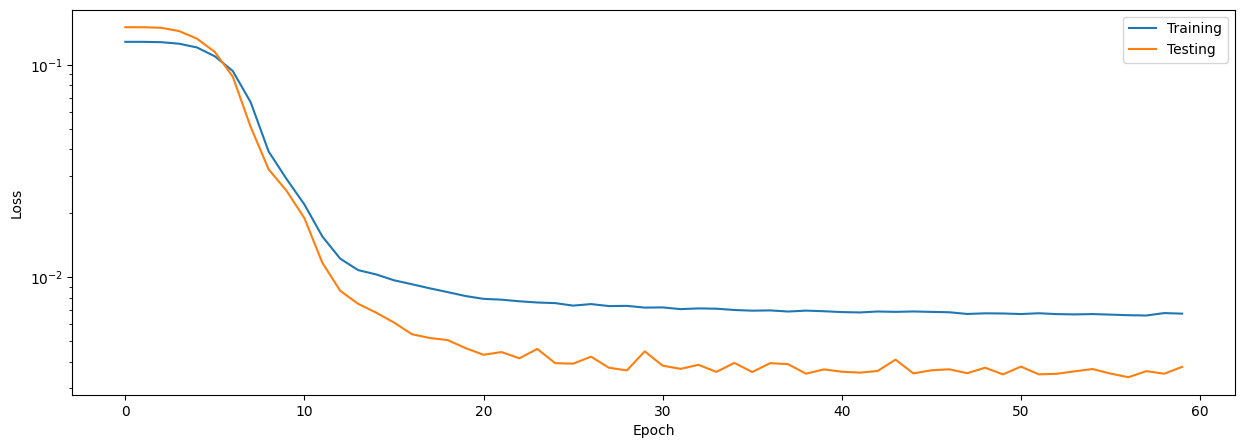

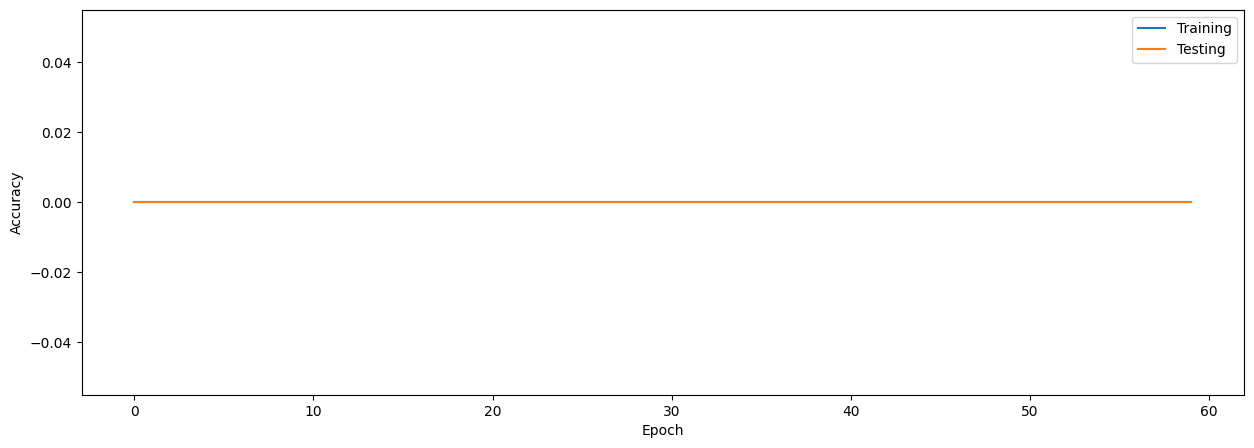

In [ ]:
stats.plot(figsize=(15, 5))

In [ ]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 3212


# SNN-MLP-Univariate-Sigma-Delta-Network-SDNN-LAVA

In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import subprocess
import time

import lava
import lava.lib.dl.slayer as slayer
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh
# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")
# ---------------------------------------------------------------------
# 2) Load, Preprocess Data
# ---------------------------------------------------------------------
#data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')

data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Select the 6th column (index=5), drop NaN
data = data.iloc[:, 5]
print(data.shape)
print(data.isnull().sum())
data.info()

data = data.dropna().astype('float64')
# Scale data
data_np = np.array(data).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_np)

train_size = int(len(data_scaled)*0.80)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

def to_sequences(dataset, seq_size=3):
    x, y = [], []
    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:i+seq_size, 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
    return np.array(x), np.array(y)

seq_size = 3
train_X, train_y = to_sequences(train_data, seq_size)
test_X,  test_y  = to_sequences(test_data, seq_size)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Convert to torch tensor
train_X = torch.tensor(train_X).float()
train_y = torch.tensor(train_y).float()
test_X  = torch.tensor(test_X).float()
test_y  = torch.tensor(test_y).float()

# Reshape for spiking networks that expect 5D [N, T, C, H, W] (as you do)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1],1,1,1))
test_X  = test_X.reshape((test_X.shape[0], test_X.shape[1],1,1,1))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# ---------------------------------------------------------------------
# 3) Spiking Network Definition
# ---------------------------------------------------------------------
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = { # sigma-delta neuron parameters
            'threshold'     : 0.05,
            'tau_grad'      : 0.05,
            'scale_grad'    : 1,
            'requires_grad' : True,
            'shared_param'  : True,
            'activation'    : F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            #slayer.block.sigma_delta.Conv(sdnn_cnn_params,  3, 32, kernel_size=1),
            #slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),
            #slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 3, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        """
        Simplified forward pass through the network without manual sparse operations.
        """
        for i, block in enumerate(self.blocks):
            # Apply the current block
            x = block(x)
           # print(f"[forward] Block {i}: x shape after processing: {x.shape}")
        # Return output, zero loss, and no count
        return x, torch.tensor(0.0).to(x.device), None

    def grad_flow(self, path):
        # If you want to track gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()
        return grad

# ---------------------------------------------------------------------
# 4) Setup training
# ---------------------------------------------------------------------
batch_size =64
lr = 0.001
lam = 0.01
epochs = 60

# Overwrite device to auto-check GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5)

training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
testing_dataset  = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_dataset,  batch_size=batch_size, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error = lambda out, tgt: F.mse_loss(out.flatten(), tgt.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam
)

trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# ---------------------------------------------------------------------
# 5) TRAINING + GPU Power Monitoring
# ---------------------------------------------------------------------
# Before starting training power monitoring
# Before starting training power monitoring
clear_log_file(train_power_log)
#monitor_proc_train = monitor_power(training_power_log)

train_power_log = "training_power_log.csv"
print("Starting training (SNN) and logging GPU power usage...")
monitor_proc_train = monitor_power(train_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    # Training loop
    for i, (input, ground_truth) in enumerate(train_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.train(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Validation loop
    net.eval()
    for i, (input, ground_truth) in enumerate(test_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.test(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Save best network
    if stats.testing.min_loss:
        torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))

    stats.update()
    stats.save(trained_folder + '/')

    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')

    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()},
                   f"{logs_folder}/checkpoint{epoch}.pt")
    print()

end_train_time = time.time()

# Stop training power logging
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time_seconds = end_train_time - start_train_time
print(f"Training complete. Took {train_time_seconds:.2f} seconds.")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) (Optional) Inference Phase to measure inference power
# ---------------------------------------------------------------------
# We'll do a short loop over test_X to measure inference.
# Before starting inference power monitoring
clear_log_file(inference_power_log)
monitor_proc_infer = monitor_power(inference_power_log)

inference_power_log = "inference_power_log.csv"
print("\nStarting 'inference' logging to measure SNN inference power usage...")
monitor_proc_infer = monitor_power(inference_power_log)
time.sleep(1)

net.eval()
with torch.no_grad():
    # Artificially repeat to simulate heavier inference
    for _ in range(1):
        for i, (input, ground_truth) in enumerate(test_loader):
            input = input.to(device)
            out, _, _ = net(input)

time.sleep(1)  # ensure logs are saved
monitor_proc_infer.terminate()
monitor_proc_infer.wait()

infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) Evaluate final test MSE on unscaled data (optional)
# ---------------------------------------------------------------------
# We'll do a single forward pass
predictions_list = []
target_list = []
net.eval()
with torch.no_grad():
    for input, ground_truth in test_loader:
        input = input.to(device)
        out, _, _ = net(input)
        predictions_list.append(out.detach().cpu())
        target_list.append(ground_truth)

preds_tensor = torch.cat(predictions_list, dim=0)
targs_tensor = torch.cat(target_list, dim=0)

# Unscale
pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1,1))
targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1,1))

mse_unnorm = ((pred_unnorm - targ_unnorm)**2).mean()
rmse_unnorm = np.sqrt(mse_unnorm)
print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
print("you may observe lower measured GPU usage relative to an ANN of similar shape.")


<ipython-input-14-047bd933f595>:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
torch.Size([21020, 3, 1, 1, 1]) torch.Size([21020]) torch.Size([5252, 3, 1, 1, 1]) torch.Size([5252])
Using device: cuda
Starting training (SNN) and logging GPU power usage...
[Epoch 1/60] Train loss =     0.08494                          accuracy = 0.00000  | Test  loss =     0.01669                          accuracy = 0.00000 
[Epoch 2/60] Train loss =     0.00834 (min =     0.08494)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00244 (min =     0.01669)     accuracy = 0.00000 (max = 0.00000) 
[Epoch 3/60] Train loss =     0.00552 (min =     0.00834)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00172 (min =     0.00244)     accuracy = 0.00000 (max = 0.0

In [ ]:
#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 70.1351
Test MAE (Unnormalized): 33.3882


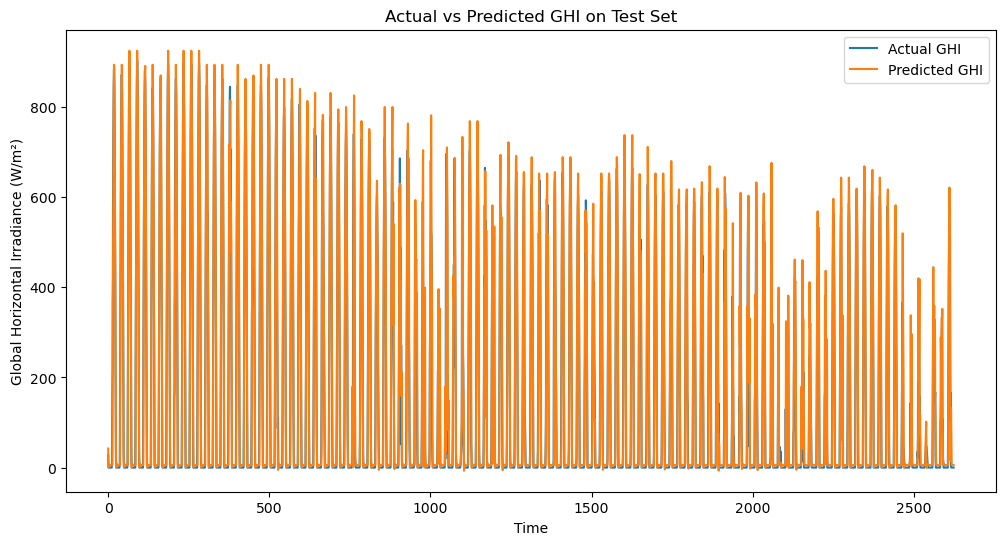

In [ ]:
# Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set
# Ensure the model is in evaluation mode
net.eval()

# Make predictions on the test set
with torch.no_grad():
    test_predictions, _, _ = net(test_X.to(device))
    test_predictions = test_predictions.cpu().numpy()

# Inverse transform the predictions and actual values
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_y_inv = scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predictions_inv))
test_mae = mean_absolute_error(test_y_inv, test_predictions_inv)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_y_inv, label='Actual GHI')
plt.plot(test_predictions_inv, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()

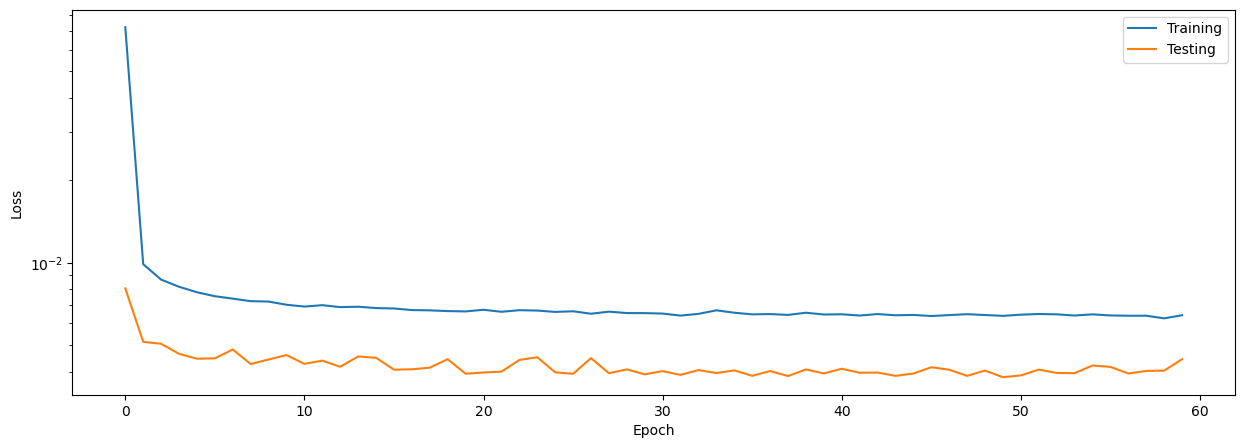

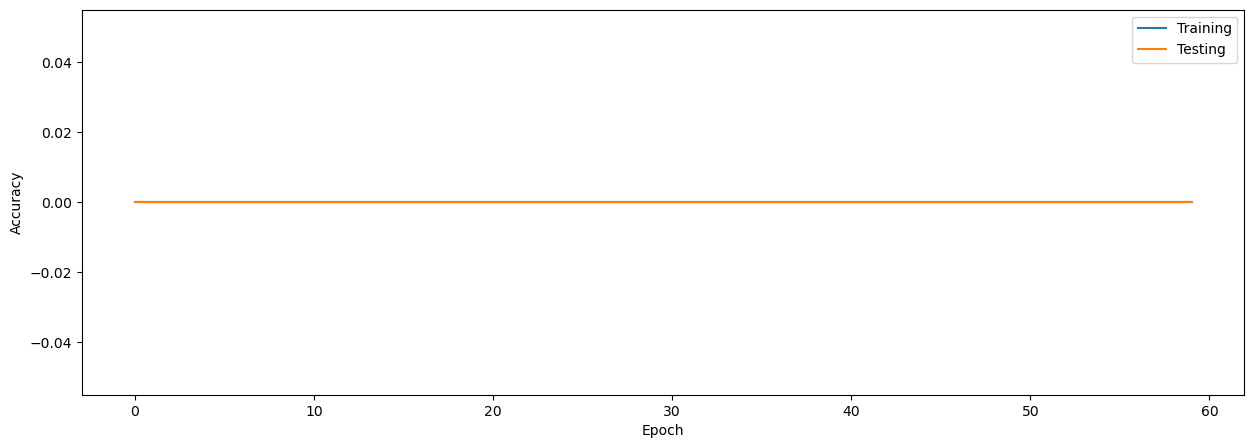

In [ ]:
stats.plot(figsize=(15, 5))

In [ ]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 1160


# Event statistics on testing dataset

In [ ]:
counts = []
for i, (input, ground_truth) in enumerate(test_loader):
    _, count = assistant.test(input, ground_truth)
    #print(count)
    count = (count.flatten()/(input.shape[-1])/input.shape[0]).tolist() # count skips first events
    counts.append(count)
    print('\rEvent count : ' + ', '.join([f'{c:.4f}' for c in count]), f'| {stats.testing}', end='')

counts = np.mean(counts, axis=0)

Event count : 0.2783, 0.8155, 0.8149, 0.0992 | loss =     0.00482 (min =     0.00467)     accuracy = 0.00000 (max = 0.00000) 

In [ ]:
import importlib.util
#spec = importlib.util.spec_from_file_location("desired_utils", "D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
spec = importlib.util.spec_from_file_location("desired_utils", "C:/Users/bahgat.ayasi/AppData/Local/anaconda3/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
desired_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(desired_utils)
# Now you can use desired_utils as the module
#desired_utils.compare_ops()


# caculayte Model Sparsity , Events and synaptic operations

In [ ]:
#utils.compare_ops(net, counts, mse=stats.testing.min_loss)
desired_utils.compare_ops(net, counts, mse=stats.testing.min_loss)

|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (  1,  1,  3) |     0.46 |              |          3 |            |
| layer-1 | (  1,  1, 32) |     0.76 |        14.74 |         32 |         96 |
| layer-2 | (  1,  1, 32) |     0.57 |        24.47 |         32 |       1024 |
| layer-3 | (  1,  1,  1) |     0.16 |         0.57 |          1 |         32 |
|-----------------------------------------------------------------------------|
|  Total  |               |     1.95 |        39.78 |         68 |       1152 |
|-----------------------------------------------------------------------------|


MSE            : 0.0045357 sq. radians

# CNN multivariat Sigma Delta nvidia-sim Energy cacluation

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

from pandas import read_csv
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))

# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)


# ---------------------------------------------------------------------
# 3) Spiking Network Definition
# ---------------------------------------------------------------------
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = { # sigma-delta neuron parameters
            'threshold'     : 0.05,
            'tau_grad'      : 0.05,
            'scale_grad'    : 1,
            'requires_grad' : True,
            'shared_param'  : True,
            'activation'    : F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,  18, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                # Masked tensor where elements of x that are greater than 0 are preserved,
                # and others are set to 0
                #masked_x = torch.where(x[..., 1:] > 0, x[..., 1:], torch.zeros_like(x[..., 1:]))
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))

                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())

        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)

    def grad_flow(self, path):
        # If you want to track gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()
        return grad

# ---------------------------------------------------------------------
# 4) Setup training
# ---------------------------------------------------------------------
batch_size =64
lr = 0.001
lam = 0.01
epochs = 60

# Overwrite device to auto-check GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5)

training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
testing_dataset  = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_dataset,  batch_size=batch_size, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error = lambda out, tgt: F.mse_loss(out.flatten(), tgt.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam
)

trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# ---------------------------------------------------------------------
# 5) TRAINING + GPU Power Monitoring
# ---------------------------------------------------------------------
# Before starting training power monitoring
clear_log_file(train_power_log)
monitor_proc_train = monitor_power(train_power_log)

train_power_log = "training_power_log.csv"
print("Starting training (SNN) and logging GPU power usage...")
monitor_proc_train = monitor_power(train_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    # Training loop
    for i, (input, ground_truth) in enumerate(train_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.train(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Validation loop
    net.eval()
    for i, (input, ground_truth) in enumerate(test_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.test(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Save best network
    if stats.testing.min_loss:
        torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))

    stats.update()
    stats.save(trained_folder + '/')

    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')

    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()},
                   f"{logs_folder}/checkpoint{epoch}.pt")
    print()

end_train_time = time.time()

# Stop training power logging
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time_seconds = end_train_time - start_train_time
print(f"Training complete. Took {train_time_seconds:.2f} seconds.")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) (Optional) Inference Phase to measure inference power
# ---------------------------------------------------------------------
# We'll do a short loop over test_X to measure inference.

# Before starting inference power monitoring
clear_log_file(inference_power_log)
monitor_proc_infer = monitor_power(inference_power_log)

inference_power_log = "inference_power_log.csv"
print("\nStarting 'inference' logging to measure SNN inference power usage...")
monitor_proc_infer = monitor_power(inference_power_log)
time.sleep(1)

net.eval()
with torch.no_grad():
    # Artificially repeat to simulate heavier inference
    for _ in range(1):
        for i, (input, ground_truth) in enumerate(test_loader):
            input = input.to(device)
            out, _, _ = net(input)

time.sleep(1)  # ensure logs are saved
monitor_proc_infer.terminate()
monitor_proc_infer.wait()

infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) Evaluate final test MSE on unscaled data (optional)
# ---------------------------------------------------------------------
# We'll do a single forward pass
predictions_list = []
target_list = []
net.eval()
with torch.no_grad():
    for input, ground_truth in test_loader:
        input = input.to(device)
        out, _, _ = net(input)
        predictions_list.append(out.detach().cpu())
        target_list.append(ground_truth)

preds_tensor = torch.cat(predictions_list, dim=0)
targs_tensor = torch.cat(target_list, dim=0)

# Unscale
pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1,1))
targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1,1))

mse_unnorm = ((pred_unnorm - targ_unnorm)**2).mean()
rmse_unnorm = np.sqrt(mse_unnorm)
print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
print("you may observe lower measured GPU usage relative to an ANN of similar shape.")


<ipython-input-16-9fff1abba210>:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.14479638 0.45317221 1.         ... 0.43611111 0.04444444 0.        ]
 [0.14479638 0.45317221 1.         ... 0.32222222 0.07777778 0.        ]
 [0.14027149 0.44712991 1.         ... 0.3        0.13333333 0.        ]
 ...
 [0.41402715 0.69486405 0.75618451 ... 0.03611111 0.07777778 0.        ]
 [0.40497738 0.6858006  0.76190991 ... 0.10555556 0.07777778 0.        ]
 [0.40045249 0.66767372 0.74192503 ... 

ValueError: non-broadcastable output operand with shape (5253,1) doesn't match the broadcast shape (5253,6)

# MLP Multivarite Sigma Delta Nvidia-sim energy calculation

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh
# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")



from pandas import read_csv
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))

# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)


# ---------------------------------------------------------------------
# 3) Spiking Network Definition
# ---------------------------------------------------------------------
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = { # sigma-delta neuron parameters
            'threshold'     : 0.05,
            'tau_grad'      : 0.05,
            'scale_grad'    : 1,
            'requires_grad' : True,
            'shared_param'  : True,
            'activation'    : F.relu,
        }
        sdnn_cnn_params = {
            **sdnn_params,
            'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }
        sdnn_dense_params = {
            **sdnn_cnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            # Input encoding
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            #slayer.block.sigma_delta.Conv(sdnn_cnn_params,  18, 32, kernel_size=1),
            #slayer.block.sigma_delta.Conv(sdnn_cnn_params, 32, 32, kernel_size=1),
            #slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 18, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                # Masked tensor where elements of x that are greater than 0 are preserved,
                # and others are set to 0
                #masked_x = torch.where(x[..., 1:] > 0, x[..., 1:], torch.zeros_like(x[..., 1:]))
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))

                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())

        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)

    def grad_flow(self, path):
        # If you want to track gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()
        return grad

# ---------------------------------------------------------------------
# 4) Setup training
# ---------------------------------------------------------------------
batch_size =64
lr = 0.001
lam = 0.01
epochs = 60

# Overwrite device to auto-check GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5)

training_dataset = torch.utils.data.TensorDataset(train_X, train_y)
testing_dataset  = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=testing_dataset,  batch_size=batch_size, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error = lambda out, tgt: F.mse_loss(out.flatten(), tgt.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam
)

trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# ---------------------------------------------------------------------
# 5) TRAINING + GPU Power Monitoring
# ---------------------------------------------------------------------

# Before starting training power monitoring
clear_log_file(train_power_log)
monitor_proc_train = monitor_power(training_power_log)

train_power_log = "training_power_log.csv"
print("Starting training (SNN) and logging GPU power usage...")
monitor_proc_train = monitor_power(train_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    # Training loop
    for i, (input, ground_truth) in enumerate(train_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.train(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Validation loop
    net.eval()
    for i, (input, ground_truth) in enumerate(test_loader):
        input, ground_truth = input.to(device), ground_truth.to(device)
        assistant.test(input, ground_truth)
        print(f"\r[Epoch {epoch+1}/{epochs}] {stats}", end="")

    # Save best network
    if stats.testing.min_loss:
        torch.save(net.state_dict(), os.path.join(trained_folder, "network.pt"))

    stats.update()
    stats.save(trained_folder + '/')

    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')

    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()},
                   f"{logs_folder}/checkpoint{epoch}.pt")
    print()

end_train_time = time.time()

# Stop training power logging
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time_seconds = end_train_time - start_train_time
print(f"Training complete. Took {train_time_seconds:.2f} seconds.")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(train_power_log)
print(f"SNN Training Energy: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) (Optional) Inference Phase to measure inference power
# ---------------------------------------------------------------------
# We'll do a short loop over test_X to measure inference.

# Before starting inference power monitoring
clear_log_file(inference_power_log)
monitor_proc_infer = monitor_power(inference_power_log)

inference_power_log = "inference_power_log.csv"
print("\nStarting 'inference' logging to measure SNN inference power usage...")
monitor_proc_infer = monitor_power(inference_power_log)
time.sleep(1)

net.eval()
with torch.no_grad():
    # Artificially repeat to simulate heavier inference
    for _ in range(1):
        for i, (input, ground_truth) in enumerate(test_loader):
            input = input.to(device)
            out, _, _ = net(input)

time.sleep(1)  # ensure logs are saved
monitor_proc_infer.terminate()
monitor_proc_infer.wait()

infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) Evaluate final test MSE on unscaled data (optional)
# ---------------------------------------------------------------------
# We'll do a single forward pass
predictions_list = []
target_list = []
net.eval()
with torch.no_grad():
    for input, ground_truth in test_loader:
        input = input.to(device)
        out, _, _ = net(input)
        predictions_list.append(out.detach().cpu())
        target_list.append(ground_truth)

preds_tensor = torch.cat(predictions_list, dim=0)
targs_tensor = torch.cat(target_list, dim=0)

# Unscale
pred_unnorm = scaler.inverse_transform(preds_tensor.numpy().reshape(-1,1))
targ_unnorm = scaler.inverse_transform(targs_tensor.numpy().reshape(-1,1))

mse_unnorm = ((pred_unnorm - targ_unnorm)**2).mean()
rmse_unnorm = np.sqrt(mse_unnorm)
print(f"\nUnscaled MSE on test set:  {mse_unnorm:.6f}")
print(f"Unscaled RMSE on test set: {rmse_unnorm:.6f}")

print("\n**Note**: Because this SNN can, in principle, be more power efficient,")
print("you may observe lower measured GPU usage relative to an ANN of similar shape.")


<ipython-input-17-fa16edc6576d>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.14479638 0.45317221 1.         ... 0.43611111 0.04444444 0.        ]
 [0.14479638 0.45317221 1.         ... 0.32222222 0.07777778 0.        ]
 [0.14027149 0.44712991 1.         ... 0.3        0.13333333 0.        ]
 ...
 [0.41402715 0.69486405 0.75618451 ... 0.03611111 0.07777778 0.        ]
 [0.40497738 0.6858006  0.76190991 ... 0.10555556 0.07777778 0.        ]
 [0.40045249 0.66767372 0.74192503 ... 

ValueError: non-broadcastable output operand with shape (5253,1) doesn't match the broadcast shape (5253,6)

# MLP Bootstrap uni

Data Shape: (26280,)
Null Values:
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Train X shape: (21020, 3), Train y shape: (21020,)
Test X shape: (5252, 3), Test y shape: (5252,)
Train X reshaped: torch.Size([21020, 3, 1, 1])
Test X reshaped: torch.Size([5252, 3, 1, 1])
Cleared existing log file: training_power_log.csv
Cleared existing log file: inference_power_log.csv
Using device: cuda
Starting training and logging GPU power usage...
                                                                                                                                                             
Mode: SNN
[Epoch  1/60]
SNN Testing: loss =     0.01500                          accuracy = 0.00000 

[Epoch  2/60] Train loss =     0.00717 (min =     0.01424)     accuracy = 0.00000 (max =

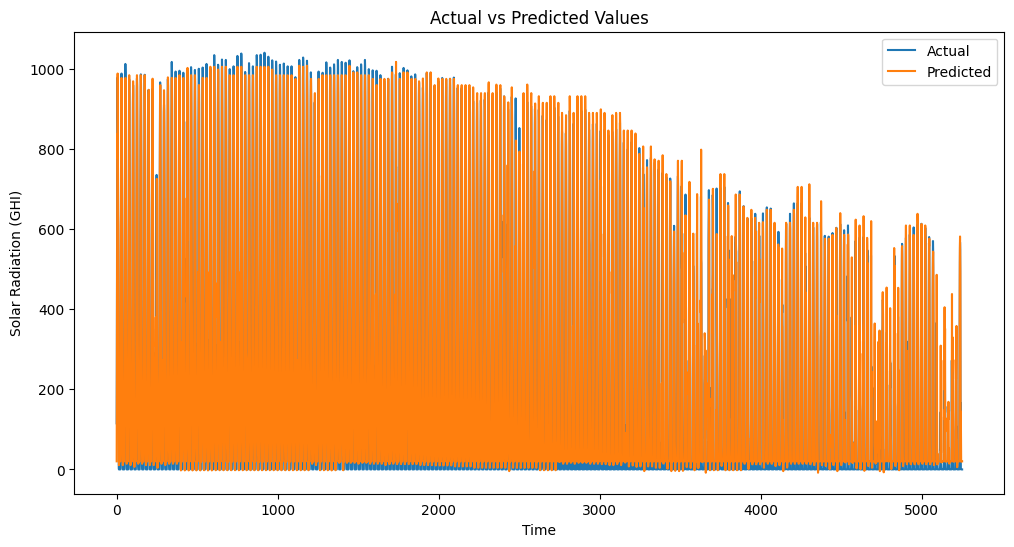


**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.
Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.


In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava


#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime
import lava.lib.dl.bootstrap as bootstrap
from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    """
    Clear the existing log file to ensure fresh data logging.
    """
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

# ---------------------------------------------------------------------
# 2) Load and Preprocess Data
# ---------------------------------------------------------------------
# Load and preprocess the dataset
#data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
# If using 'Palestine-PV.csv', uncomment the following line:
data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')

# Convert index to datetime and sort
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Select the 6th column (index=5), drop NaN values
data = data.iloc[:, 5]
print(f"Data Shape: {data.shape}")
print(f"Null Values:\n{data.isnull().sum()}")
data.info()

# Remove NaN values and ensure data type is float64
data = data.dropna().astype('float64')

# Convert the Series to a numpy array and reshape
data = np.array(data).reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# Create sequences for LSTM/SNN
def to_sequences(dataset, seq_size=3):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x), np.array(y)

seq_size =3  # Number of time steps to look back

train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(f"Train X shape: {train_X.shape}, Train y shape: {train_y.shape}")
print(f"Test X shape: {test_X.shape}, Test y shape: {test_y.shape}")

# Convert to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).view(-1, 1)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).view(-1, 1)

# Reshape for Conv4d: (Batch, Channels, Height, Width)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1,1 ))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test X reshaped: {test_X.shape}")

# ---------------------------------------------------------------------
# 3) Spiking Neural Network (SNN) Definition
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 3, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)


        return x

# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
# Define log file paths
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

# Instantiate Network, Optimizer, Dataset and DataLoader
batch  =64  # Batch size
lr     = 0.001 # Learning rate
lam    = 0.01  # Lagrangian for event rate loss
epochs =60     # Training epochs
steps  = [60, 120, 160] # Learning rate reduction milestones
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Set device (Ensure GPU is selected in Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Network and Optimizer
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones

# Prepare DataLoaders
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) TRAINING LOOP WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Start power monitoring before training
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # Reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Compute the event rate

            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')

    # Calculate the mean event rate
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()

# Stop the power monitoring for training
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) INFERENCE WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)

# Start power monitoring before inference
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)

start_infer_time = time.time()

# Inference phase
net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust the range to simulate workload
        for i, (input, label) in enumerate(test_loader):
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

end_infer_time = time.time()

# Stop the power monitoring for inference
monitor_proc_infer.terminate()
monitor_proc_infer.wait()
infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) FINAL EVALUATION
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate final test MSE and MAE on unscaled data
all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for input, label in test_loader:
        input = input.to(device)
        output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and actual values
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm = scaler.inverse_transform(all_labels)

# Calculate RMSE and MAE
mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set: {mae:.6f}")

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.")
print("Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.")


# CNN Bootstrap uni

<ipython-input-4-44866a1b841e>:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


Data Shape: (26280,)
Null Values:
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Train X shape: (21020, 3), Train y shape: (21020,)
Test X shape: (5252, 3), Test y shape: (5252,)
Train X reshaped: torch.Size([21020, 3, 1, 1])
Test X reshaped: torch.Size([5252, 3, 1, 1])
Cleared existing log file: training_power_log.csv
Cleared existing log file: inference_power_log.csv
Using device: cuda
Starting training and logging GPU power usage...
                                                                                                                                                             
Mode: SNN
[Epoch  1/60]
SNN Testing: loss =     0.05739                          accuracy = 0.00000 

[Epoch  2/60] Train loss =     0.00399 (min =     0.02105)     accuracy = 0.00000 (max =

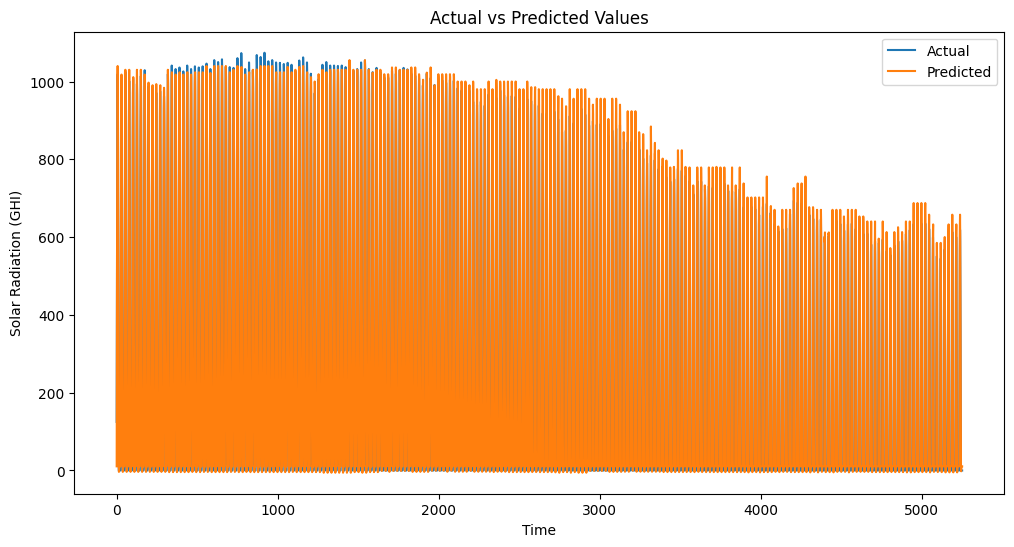


**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.
Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.


In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava


#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime
import lava.lib.dl.bootstrap as bootstrap
from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    """
    Clear the existing log file to ensure fresh data logging.
    """
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

# ---------------------------------------------------------------------
# 2) Load and Preprocess Data
# ---------------------------------------------------------------------
# Load and preprocess the dataset
data = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
# If using 'Palestine-PV.csv', uncomment the following line:
#data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')

# Convert index to datetime and sort
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Select the 6th column (index=5), drop NaN values
data = data.iloc[:, 5]
print(f"Data Shape: {data.shape}")
print(f"Null Values:\n{data.isnull().sum()}")
data.info()

# Remove NaN values and ensure data type is float64
data = data.dropna().astype('float64')

# Convert the Series to a numpy array and reshape
data = np.array(data).reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

# Create sequences for LSTM/SNN
def to_sequences(dataset, seq_size=3):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x), np.array(y)

seq_size =3  # Number of time steps to look back

train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(f"Train X shape: {train_X.shape}, Train y shape: {train_y.shape}")
print(f"Test X shape: {test_X.shape}, Test y shape: {test_y.shape}")

# Convert to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).view(-1, 1)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).view(-1, 1)

# Reshape for Conv4d: (Batch, Channels, Height, Width)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1,1 ))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test X reshaped: {test_X.shape}")

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Conv(neuron_params_norm,3,32, kernel_size=1),
                bootstrap.block.cuba.Conv(neuron_params_norm,32,32, kernel_size=1),
                bootstrap.block.cuba.Flatten(),
                bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)


        return x

# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
# Define log file paths
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

# Instantiate Network, Optimizer, Dataset and DataLoader
batch  =64  # Batch size
lr     = 0.001 # Learning rate
lam    = 0.01  # Lagrangian for event rate loss
epochs =60     # Training epochs
steps  = [60, 120, 160] # Learning rate reduction milestones
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Set device (Ensure GPU is selected in Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Network and Optimizer
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones

# Prepare DataLoaders
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) TRAINING LOOP WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Start power monitoring before training
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # Reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Compute the event rate

            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')

    # Calculate the mean event rate
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()

# Stop the power monitoring for training
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) INFERENCE WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)

# Start power monitoring before inference
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)

start_infer_time = time.time()

# Inference phase
net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust the range to simulate workload
        for i, (input, label) in enumerate(test_loader):
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

end_infer_time = time.time()

# Stop the power monitoring for inference
monitor_proc_infer.terminate()
monitor_proc_infer.wait()
infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) FINAL EVALUATION
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate final test MSE and MAE on unscaled data
all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for input, label in test_loader:
        input = input.to(device)
        output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and actual values
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm = scaler.inverse_transform(all_labels)

# Calculate RMSE and MAE
mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set: {mae:.6f}")

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.")
print("Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.")

# MLP Bootstrap Multi

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava


#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime
import lava.lib.dl.bootstrap as bootstrap
from pandas import read_csv

import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

from pandas import read_csv
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1

# Reshape for Conv4d: (Batch, Channels, Height, Width)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1,1 ))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test X reshaped: {test_X.shape}")

# ---------------------------------------------------------------------
# 3) Spiking Neural Network (SNN) Definition
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 18, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)


        return x

# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
# Define log file paths
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

# Instantiate Network, Optimizer, Dataset and DataLoader
batch  =64  # Batch size
lr     = 0.001 # Learning rate
lam    = 0.01  # Lagrangian for event rate loss
epochs =60     # Training epochs
steps  = [60, 120, 160] # Learning rate reduction milestones
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Set device (Ensure GPU is selected in Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Network and Optimizer
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones

# Prepare DataLoaders
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) TRAINING LOOP WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Start power monitoring before training
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # Reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Compute the event rate

            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')

    # Calculate the mean event rate
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()

# Stop the power monitoring for training
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) INFERENCE WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)

# Start power monitoring before inference
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)

start_infer_time = time.time()

# Inference phase
net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust the range to simulate workload
        for i, (input, label) in enumerate(test_loader):
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

end_infer_time = time.time()

# Stop the power monitoring for inference
monitor_proc_infer.terminate()
monitor_proc_infer.wait()
infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) FINAL EVALUATION
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate final test MSE and MAE on unscaled data
all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for input, label in test_loader:
        input = input.to(device)
        output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and actual values
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm = scaler.inverse_transform(all_labels)

# Calculate RMSE and MAE
mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set: {mae:.6f}")

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.")
print("Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.18387909 0.41533546 0.81315346 ... 0.21388889 0.09433962 0.        ]
 [0.17632242 0.41533546 0.82833052 ... 0.25       0.11320755 0.        ]
 [0.17128463 0.41214058 0.83552558 ... 0.275      0.16981132 0.        ]
 ...
 [0.39042821 0.73801917 0.94738617 ... 0.07222222 0.1509434  0.        ]
 [0.38790932 0.73482428 0.94749859 ... 0.09444444 0.11320755 0.        ]
 [0.38539043 0.7284345  0.93715571 ... 

ValueError: non-broadcastable output operand with shape (5253,1) doesn't match the broadcast shape (5253,6)

# CNN Bootstrap Multi

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava


#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime
import lava.lib.dl.bootstrap as bootstrap
from pandas import read_csv

import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

from pandas import read_csv
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1

# Reshape for Conv4d: (Batch, Channels, Height, Width)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1,1 ))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test X reshaped: {test_X.shape}")

# ---------------------------------------------------------------------
# 3) Spiking Neural Network (SNN) Definition
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Conv(neuron_params_norm,18,32, kernel_size=1),
                bootstrap.block.cuba.Conv(neuron_params_norm,32,32, kernel_size=1),
                bootstrap.block.cuba.Flatten(),
                bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)


        return x

# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
# Define log file paths
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

# Instantiate Network, Optimizer, Dataset and DataLoader
batch  =64  # Batch size
lr     = 0.001 # Learning rate
lam    = 0.01  # Lagrangian for event rate loss
epochs =60     # Training epochs
steps  = [60, 120, 160] # Learning rate reduction milestones
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Set device (Ensure GPU is selected in Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Network and Optimizer
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones

# Prepare DataLoaders
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) TRAINING LOOP WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Start power monitoring before training
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # Reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Compute the event rate

            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')

    # Calculate the mean event rate
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()

# Stop the power monitoring for training
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) INFERENCE WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)

# Start power monitoring before inference
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)

start_infer_time = time.time()

# Inference phase
net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust the range to simulate workload
        for i, (input, label) in enumerate(test_loader):
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

end_infer_time = time.time()

# Stop the power monitoring for inference
monitor_proc_infer.terminate()
monitor_proc_infer.wait()
infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) FINAL EVALUATION
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate final test MSE and MAE on unscaled data
all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for input, label in test_loader:
        input = input.to(device)
        output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and actual values
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm = scaler.inverse_transform(all_labels)

# Calculate RMSE and MAE
mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set: {mae:.6f}")

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.")
print("Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.")


<ipython-input-3-786382c8903e>:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.14479638 0.45317221 1.         ... 0.43611111 0.04444444 0.        ]
 [0.14479638 0.45317221 1.         ... 0.32222222 0.07777778 0.        ]
 [0.14027149 0.44712991 1.         ... 0.3        0.13333333 0.        ]
 ...
 [0.41402715 0.69486405 0.75618451 ... 0.03611111 0.07777778 0.        ]
 [0.40497738 0.6858006  0.76190991 ... 0.10555556 0.07777778 0.        ]
 [0.40045249 0.66767372 0.74192503 ... 

ValueError: non-broadcastable output operand with shape (5253,1) doesn't match the broadcast shape (5253,6)

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava


#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime
import lava.lib.dl.bootstrap as bootstrap
from pandas import read_csv

import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

from pandas import read_csv
# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

# Add this at the beginning of your script or before starting power monitoring
def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")

from pandas import read_csv
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1

# Reshape for Conv4d: (Batch, Channels, Height, Width)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1,1 ))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test X reshaped: {test_X.shape}")

# ---------------------------------------------------------------------
# 3) Spiking Neural Network (SNN) Definition
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold':     0.5,
            'current_decay': 1,       # must be 1 to use batchnorm
            'voltage_decay': 0.03,
            'tau_grad':      1,
            'scale_grad':    1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),
        }

        # The original bootstrapped blocks
        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),
            bootstrap.block.cuba.Conv(neuron_params_norm, 18, 32, kernel_size=1),
            bootstrap.block.cuba.Conv(neuron_params_norm, 32, 32, kernel_size=1),
            bootstrap.block.cuba.Flatten(),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode, sparse_inference=False):
        """
        Forward pass with optional manual cuSPARSE ops *only* in inference.

        Args:
          x: Input tensor.
          mode: The scheduler mode from bootstrap.
          sparse_inference (bool):
              If True => attempt manual cuSPARSE for certain blocks (only if not self.training).
              If False => use normal forward pass.
        """
        # Expand time dimension if in SNN mode
        if mode.base_mode == bootstrap.Mode.SNN:
            x = slayer.utils.time.replicate(x, self.time_steps)
        else:
            # e.g. for ANN mode, might be 5D -> [Batch, Chan, H, W, time]
            # or keep your normal shape
            x = x.unsqueeze(-1)  # if needed

        # Pass through each block in sequence
        for block, m in zip(self.blocks, mode):
            if self.training or (not sparse_inference):
                # Normal forward (preserves gradient).
                x = block(x, mode=m)
            else:
                # Evaluate + sparse_inference => do manual cuSPARSE if possible
                x = block(x, mode=m)  # first do the block's normal ops (like BN, dropout in eval)

                # Attempt manual cuSPARSE if this is a Conv/Dense block
                if isinstance(block, bootstrap.block.cuba.Conv):
                    x = self._sparse_conv_forward(x, block)
                elif isinstance(block, bootstrap.block.cuba.Dense):
                    x = self._sparse_dense_forward(x, block)
                else:
                    # Input, Flatten, Affine => skip for brevity or do a simpler approach
                    pass

        return x

    def _sparse_conv_forward(self, x, block):
        """
        Example: Manually apply cuSPARSE after a Conv block in inference.
        x shape: [batch, out_channels, height, width, time] for SNN
                 or [batch, out_channels, height, width] for ANN
        block has 'synapse.weight' shaped like [out_chan, in_chan, kH, kW, ...]
        """
        # This is tricky with actual convolution shapes. For a kernel_size=1, we can flatten.
        # If kernel_size > 1, you'd need an actual convolution routine in CuPy.
        # We'll do a simple "1x1 conv" example: flatten + matmul.

        # Convert x to shape [batch, features]
        original_shape = x.shape
        # For example [N, outC, 1, 1, T]
        # Flatten ignoring time dimension => we'll show a naive approach:
        # This is a toy approach for demonstration. For real kernels>1, you'd need custom code.

        # Remove 'time' if present
        if x.dim() == 5:  # [N, C, H, W, T]
            N, C, H, W, T = x.shape
            x_reshaped = x.reshape(N * T, C * H * W)
        else:  # [N, C, H, W]
            N, C, H, W = x.shape
            x_reshaped = x.reshape(N, C * H * W)

        # Convert to sparse
        x_np = x_reshaped.detach().cpu().numpy()
        x_sparse = scipy_csr_matrix(x_np)
        x_sparse = cupy_csr_matrix(x_sparse)  # GPU

        # Reshape block weights for a 1x1 conv
        W = block.synapse.weight.detach().cpu().numpy()
        # shape might be [outC, inC, 1, 1, 1] or [outC, inC, 1, 1].
        outC, inC = W.shape[:2]
        # Flatten
        W_reshaped = W.reshape(outC, inC)
        w_sparse = cupy_csr_matrix(scipy_csr_matrix(W_reshaped))

        # Sparse matmul => [batch, inC] * [inC, outC] = [batch, outC]
        x_sparse = x_sparse.dot(w_sparse.T)
        # Convert back
        x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)

        # Reshape back to original
        if x.dim() == 5:
            # after matmul => shape = [N*T, outC]
            x = x_dense.reshape(N, T, outC, 1, 1)  # some reordering
            x = x.permute(0, 2, 3, 4, 1)  # back to [N, outC, 1, 1, T]
        else:
            # after matmul => shape = [N, outC]
            x = x_dense.reshape(N, outC, 1, 1)
        return x

    def _sparse_dense_forward(self, x, block):
        """
        Example: Manually apply cuSPARSE after a Dense block in inference.
        x shape might be [N, features, 1, 1, T] or [N, features, 1, 1] or [N, features].
        block weights => block.synapse.weight shape: [out_features, in_features, ...]
        """
        original_shape = x.shape
        # Flatten ignoring time if present
        if x.dim() == 5:  # [N, feats, 1, 1, T]
            N, feats, _, _, T = x.shape
            x_reshaped = x.reshape(N * T, feats)
        elif x.dim() == 4:  # [N, feats, 1, 1]
            N, feats, _, _ = x.shape
            x_reshaped = x.reshape(N, feats)
        else:
            # [N, feats], no re-shape needed
            x_reshaped = x.reshape(-1, x.shape[1])

        # Convert x to sparse
        x_np = x_reshaped.detach().cpu().numpy()
        x_sparse = cupy_csr_matrix(scipy_csr_matrix(x_np))

        # Reshape block weights
        W = block.synapse.weight.detach().cpu().numpy()
        out_features, in_features = W.shape[:2]
        W_reshaped = W.reshape(out_features, in_features)
        w_sparse = cupy_csr_matrix(scipy_csr_matrix(W_reshaped))

        # Sparse matmul => [batch, in_features] x [in_features, out_features] => [batch, out_features]
        x_sparse = x_sparse.dot(w_sparse.T)
        x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)

        # Reshape back
        if x.dim() == 5:
            # was [N*T, feats] => => [N, T, out_features, 1, 1]
            if out_features == 1:
                x = x_dense.reshape(N, T, 1, 1, 1)
                x = x.permute(0, 2, 3, 4, 1)  # => [N, 1, 1, 1, T]
            else:
                x = x_dense.reshape(N, T, out_features, 1, 1)
                x = x.permute(0, 2, 3, 4, 1)  # => [N, outF, 1, 1, T]
        elif x.dim() == 4:
            # was [N, feats] => => [N, out_features, 1, 1]
            x = x_dense.reshape(-1, out_features, 1, 1)
        else:
            # was [N, feats] => => [N, out_features]
            x = x_dense.reshape(-1, out_features)
        return x

# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
# Define log file paths
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"

# Clear existing log files
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

# Instantiate Network, Optimizer, Dataset and DataLoader
batch  =64  # Batch size
lr     = 0.001 # Learning rate
lam    = 0.01  # Lagrangian for event rate loss
epochs =60     # Training epochs
steps  = [60, 120, 160] # Learning rate reduction milestones
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

# Set device (Ensure GPU is selected in Colab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize Network and Optimizer
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones

# Prepare DataLoaders
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) TRAINING LOOP WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Start power monitoring before training
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)

start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # Reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Compute the event rate

            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]

    print(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}', end='')

    # Calculate the mean event rate
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()

# Stop the power monitoring for training
monitor_proc_train.terminate()
monitor_proc_train.wait()
train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) INFERENCE WITH ENERGY MONITORING
# ---------------------------------------------------------------------
# Clear existing inference log file
clear_log_file(inference_power_log)

# Start power monitoring before inference
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)

start_infer_time = time.time()

# Inference phase
net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust the range to simulate workload
        for i, (input, label) in enumerate(test_loader):
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

end_infer_time = time.time()

# Stop the power monitoring for inference
monitor_proc_infer.terminate()
monitor_proc_infer.wait()
infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) FINAL EVALUATION
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate final test MSE and MAE on unscaled data
all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for input, label in test_loader:
        input = input.to(device)
        output = net.forward(input, mode=scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform the predictions and actual values
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm = scaler.inverse_transform(all_labels)

# Calculate RMSE and MAE
mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set: {mae:.6f}")

# Plotting predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption during training and inference phases.")
print("Ensure that your Colab runtime is set to GPU to enable accurate energy monitoring via nvidia-smi.")


<ipython-input-28-644ec2f7942c>:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.14479638 0.45317221 1.         ... 0.43611111 0.04444444 0.        ]
 [0.14479638 0.45317221 1.         ... 0.32222222 0.07777778 0.        ]
 [0.14027149 0.44712991 1.         ... 0.3        0.13333333 0.        ]
 ...
 [0.41402715 0.69486405 0.75618451 ... 0.03611111 0.07777778 0.        ]
 [0.40497738 0.6858006  0.76190991 ... 0.10555556 0.07777778 0.        ]
 [0.40045249 0.66767372 0.74192503 ... 

RuntimeError: Given groups=1, weight of size [32, 3, 1, 1, 1], expected input[64, 18, 1, 1, 1] to have 3 channels, but got 18 channels instead

In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer

import subprocess
import time
import lava

import pandas as pd
from pandas import read_csv, DataFrame, concat, to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import lava.lib.dl.bootstrap as bootstrap

# -----------------------------
# Extra imports for cuSPARSE
# -----------------------------
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cupy_csr_matrix
from scipy.sparse import csr_matrix as scipy_csr_matrix


# ---------------------------------------------------------------------
# 1) GPU Power Monitoring Utilities
# ---------------------------------------------------------------------
def monitor_power(output_file):
    """
    Launch nvidia-smi in the background, capturing instantaneous GPU power usage every 1 second.
    """
    command = f"nvidia-smi --query-gpu=power.draw --format=csv -l 1 > {output_file}"
    process = subprocess.Popen(command, shell=True)
    return process

def calculate_energy_consumption(log_file):
    """
    Read GPU power usage (watts) from a CSV log generated by nvidia-smi.
    Each line is power at 1-second intervals -> sum -> total Joules, then convert to kWh.
    """
    data = pd.read_csv(log_file, skiprows=1, names=["Power (W)"])

    print(f"\n=== Debug: Power log file content ===\n{data.head()}")

    # Extract numeric portion (remove ' W' if present)
    data["Power (W)"] = data["Power (W)"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    print(f"Cleaned log data:\n{data.head()}")

    # Summation of power usage in 1-second intervals => total Joules
    energy_joules = data["Power (W)"].sum()
    energy_kwh = energy_joules / (3600.0 * 1000.0)

    return energy_joules, energy_kwh

def clear_log_file(log_file):
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"Cleared existing log file: {log_file}")


# ---------------------------------------------------------------------
# 2) Load Data + Preprocessing
# ---------------------------------------------------------------------
dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()
dataset = dataset[~np.isnan(dataset)]
dataset = dataset.dropna()
dataset.info()
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is last
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]
            names.append(target_col_name + '(t)')
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    # Keep only target predictions from future steps, remove other columns
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    if dropnan:
        agg.dropna(inplace=True)

    return agg

values = dataset.values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)

# Also scale target separately if desired
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])

# Frame as supervised learning: 3 steps in, 1 step out
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)

# Split into train/test
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test  = values[n_train_hours:, :]

# split into input (X) and outputs (y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X,  test_y  = test[:, :-1],  test[:, -1]

print("train_X:", train_X.shape, "train_y:", train_y.shape,
      "test_X:", test_X.shape,   "test_y:", test_y.shape)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X  = torch.Tensor(test_X)
test_y  = torch.Tensor(test_y)

# Reshape to (Batch, Features, 1,1)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1,1))
test_X  = test_X.reshape((test_X.shape[0],  test_X.shape[1],  1,1))
print(f"Train X reshaped: {train_X.shape}")
print(f"Test  X reshaped: {test_X.shape}")


# ---------------------------------------------------------------------
# 3) Fully Connected Spiking Network with optional cuSPARSE
# ---------------------------------------------------------------------
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold'     : 0.5,
            'current_decay' : 1,       # must be 1 to use batchnorm
            'voltage_decay' : 0.03,
            'tau_grad'      : 1,
            'scale_grad'    : 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
            # 'dropout': slayer.neuron.Dropout(p=0.2),
        }

        # Replace Conv blocks with Flatten + Dense
        # We assume input has shape [N, 18, 1, 1] => Flatten => [N, 18]
        # Then Dense(18->32), Dense(32->32), final Affine(32->1).
        self.blocks = torch.nn.ModuleList([
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),
            #bootstrap.block.cuba.Flatten(),
            bootstrap.block.cuba.Dense(neuron_params_norm, 18, 32),
            bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
            bootstrap.block.cuba.Affine(neuron_params, 32, 1),
        ])

    def forward(self, x, mode, sparse_inference=False):
        """
        Forward pass with optional manual cuSPARSE ops *only* in inference.
        """
        # Expand time dimension if in SNN mode
        if mode.base_mode == bootstrap.Mode.SNN:
            x = slayer.utils.time.replicate(x, self.time_steps)
        else:
            # Possibly add time dim if needed
            x = x.unsqueeze(-1)

        for block, m in zip(self.blocks, mode):
            if self.training or (not sparse_inference):
                # Normal forward => preserves gradient
                x = block(x, mode=m)
            else:
                # Evaluate + sparse_inference => do manual cuSPARSE for Dense
                x = block(x, mode=m)  # let block do BN/Dropout in eval
                if isinstance(block, bootstrap.block.cuba.Dense):
                    x = self._sparse_dense_forward(x, block)
                # Flatten, Affine => skip or special handling if you want
                # For demonstration, we only do manual sparse ops on Dense

        return x

    def _sparse_dense_forward(self, x, block):
        """
        Example: Manually apply cuSPARSE after a Dense block in inference.
        x shape might be [N, features, 1, 1, T] or [N, features, 1, 1] or [N, features].
        """
        # Flatten ignoring time if present
        if x.dim() == 5:  # [N, feats, 1, 1, T]
            N, feats, _, _, T = x.shape
            x_reshaped = x.reshape(N * T, feats)
        elif x.dim() == 4:  # [N, feats, 1, 1]
            N, feats, _, _ = x.shape
            x_reshaped = x.reshape(N, feats)
        else:
            x_reshaped = x.reshape(-1, x.shape[1])

        # Convert x to sparse
        x_np = x_reshaped.detach().cpu().numpy()
        x_sparse = cupy_csr_matrix(scipy_csr_matrix(x_np))

        # Reshape block weights
        W = block.synapse.weight.detach().cpu().numpy()
        out_features, in_features = W.shape[:2]
        W_reshaped = W.reshape(out_features, in_features)
        w_sparse = cupy_csr_matrix(scipy_csr_matrix(W_reshaped))

        # Sparse matmul => [batch, in_features] x [in_features, out_features]
        x_sparse = x_sparse.dot(w_sparse.T)
        x_dense = torch.tensor(x_sparse.todense(), device=x.device, dtype=torch.float32)

        # Reshape back
        if x.dim() == 5:
            # [N*T, out_features] => => [N, T, out_features, 1, 1]
            x = x_dense.reshape(N, T, out_features, 1, 1)
            # reorder to [N, out_features, 1, 1, T]
            x = x.permute(0, 2, 3, 4, 1)
        elif x.dim() == 4:
            x = x_dense.reshape(-1, out_features, 1, 1)
        else:
            x = x_dense.reshape(-1, out_features)
        return x


# ---------------------------------------------------------------------
# 4) Setup Training and Energy Monitoring
# ---------------------------------------------------------------------
training_power_log = "training_power_log.csv"
inference_power_log = "inference_power_log.csv"
clear_log_file(training_power_log)
clear_log_file(inference_power_log)

batch  = 64
lr     = 0.001
lam    = 0.01
epochs = 60
trained_folder = 'Trained'
logs_folder    = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set  = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set,  batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# ---------------------------------------------------------------------
# 5) Training Loop with Energy Monitoring
# ---------------------------------------------------------------------
print("Starting training and logging GPU power usage...")
monitor_proc_train = monitor_power(training_power_log)
start_train_time = time.time()

for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    for i, (input_data, label) in enumerate(train_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)

        input_data = input_data.to(device)
        output = net.forward(input_data, mode)  # normal training forward
        rate = torch.mean(output, dim=-1).reshape((input_data.shape[0], -1))

        label = label.view(-1, 1).to(device)
        loss = F.mse_loss(rate, label)

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input_data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    net.eval()
    counts = []
    for i, (input_data, label) in enumerate(test_loader, 0):
        mode = scheduler.mode(epoch, i, net.training)
        with torch.no_grad():
            input_data = input_data.to(device)
            output = net.forward(input_data, mode)  # normal forward in eval
            rate = torch.mean(output, dim=-1).reshape((input_data.shape[0], -1))

            label = label.view(-1, 1).to(device)
            loss = F.mse_loss(rate, label)

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input_data.shape[0]

    print(f"\r[Epoch {epoch+1:2d}/{epochs}] {stats}", end="")

    # SNN stat handling
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' ' * len(f'\r[Epoch {epoch+1:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch+1:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')
        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), os.path.join(trained_folder, 'network.pt'))
        scheduler.update_snn_stat()

    stats.update()
    stats.save(os.path.join(trained_folder, '/'))
    print()

end_train_time = time.time()
monitor_proc_train.terminate()
monitor_proc_train.wait()

train_time = end_train_time - start_train_time
print(f"Training complete. Took {train_time:.2f} seconds.")
print("Calculating energy consumption for training...")
train_energy_joules, train_energy_kwh = calculate_energy_consumption(training_power_log)
print(f"SNN Training Energy Consumption: {train_energy_joules:.2f} Joules ({train_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 6) Inference with Energy Monitoring
# ---------------------------------------------------------------------
clear_log_file(inference_power_log)
print("\nStarting inference and logging GPU power usage...")
monitor_proc_infer = monitor_power(inference_power_log)
start_infer_time = time.time()

net.eval()
with torch.no_grad():
    for _ in range(1):  # Adjust if needed
        for i, (input_data, label) in enumerate(test_loader):
            input_data = input_data.to(device)
            # If you want to test cuSPARSE inference => add sparse_inference=True
            output = net.forward(input_data, scheduler.mode(epochs-1, i, False),
                                 sparse_inference=True)
            rate = torch.mean(output, dim=-1).reshape((input_data.shape[0], -1))

end_infer_time = time.time()
monitor_proc_infer.terminate()
monitor_proc_infer.wait()

infer_time = end_infer_time - start_infer_time
print(f"Inference complete. Took {infer_time:.2f} seconds.")
print("Calculating energy consumption for inference...")
infer_energy_joules, infer_energy_kwh = calculate_energy_consumption(inference_power_log)
print(f"SNN Inference Energy Consumption: {infer_energy_joules:.2f} Joules ({infer_energy_kwh:.6f} kWh)")

# ---------------------------------------------------------------------
# 7) Final Evaluation
# ---------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

all_predictions = []
all_labels = []

net.eval()
with torch.no_grad():
    for i, (input_data, label) in enumerate(test_loader):
        input_data = input_data.to(device)
        output = net.forward(input_data, scheduler.mode(epochs-1, i, False))
        rate = torch.mean(output, dim=-1).reshape((input_data.shape[0], -1))
        all_predictions.append(rate.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Inverse transform
predictions_unnorm = scaler.inverse_transform(all_predictions)
test_y_unnorm       = scaler.inverse_transform(all_labels.reshape(-1,1))

mse = mean_squared_error(test_y_unnorm, predictions_unnorm)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test_y_unnorm, predictions_unnorm)

print(f"\nUnnormalized MSE on test set:  {mse:.6f}")
print(f"Unnormalized RMSE on test set: {rmse:.6f}")
print(f"Unnormalized MAE on test set:  {mae:.6f}")

plt.figure(figsize=(12,6))
plt.plot(test_y_unnorm, label='Actual')
plt.plot(predictions_unnorm, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.show()

print("\n**Note**: The energy measurements represent the GPU's power consumption.")
print("Ensure your environment is set to GPU to enable accurate nvidia-smi monitoring.")


         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox


<ipython-input-1-c15ddfb1de50>:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
train_X: (21024, 18) train_y: (21024,) test_X: (5253, 18) test_y: (5253,)
Train X reshaped: torch.Size([21024, 18, 1, 1])
Test  X reshaped: torch.Size([5253, 18, 1, 1])
Cleared existing log file: training_power_log.csv
Using device: cuda
Starting training and logging GPU power usage...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                                                                                                                                                             
Mode: SNN
[Epoch  1/60]
SNN Testing: loss =     0.16130                          accuracy = 0.00000 

[Epoch  2/60] Train loss =     0.14451 (min =     0.14450)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.16130 (min =     0.16130)     accuracy = 0.00000 (max = 0.00000) 
[Epoch  3/60] Train loss =     0.14451 (min =     0.14450)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.16130 (min =     0.16130)     accuracy = 0.00000 (max = 0.00000) 
[Epoch  4/60] Train loss =     0.14451 (min =     0.14450)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.16130 (min =     0.16130)     accuracy = 0.00000 (max = 0.00000) 
[Epoch  5/60] Train loss =     0.14451 (min =     0.14450)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.16130 (min =     0.16130)     accuracy = 0.00000 (max = 0.0000

ValueError: mismatched shape